In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [8]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model_h as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
import interior_seq

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/media/scratch1/erbachj/Mask_RCNN
The tensorboard module is not an IPython extension.
finished


In [9]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [10]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']

selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'curtain', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
# without curtain
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [11]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 0, 10: 8, 11: 6, 12: 0, 13: 7, 14: 5, 15: 8, 16: 0, 17: 9, 18: 10, 19: 11, 20: 0, 21: 12, 22: 0, 23: 13, 24: 14, 25: 15, 26: 16, 27: 17, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 18, 34: 19, 35: 20, 36: 21, 37: 22, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [12]:
#TRAIN_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDDWIQX7_Dining_room'
#TRAIN_DIR = os.path.join(TRAIN_DIR,'cam0/data/')
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior_seq.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior_seq.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7
HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4K9BL11ER_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4K9BL11ER_Guest_room_id0
3FO4K9BL11ER_Guest_room_id1
3FO4K9BL11ER_Guest_room_id2
3FO4K9BL11ER_Guest_room_id3
3FO4K9BL11ER_Guest_room_id4
3FO4K9BL11ER_Guest_room_id5
3FO4K9BL11ER_Guest_room_id6
3FO4K9BL11ER_Guest_room_id7
3FO4K9BL11ER_Guest_room_id8
3FO4K9BL11ER_Guest_room_id9
3FO4K9BL11ER_Guest_room_id12
3FO4K9BL11ER_Guest_room_id13
3FO4K9BL11ER_Guest_room_id14
3FO4K9BL11ER_Guest_room_id15
3FO4K9BL11ER_Guest_room_id16
3FO4K9BL11ER_Guest_room_id17
3FO4K9BL11ER_Guest_room_id18
3FO4K9BL11ER_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JJA8WOJP_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JJA8WOJP_Living_room_id0
3FO4JJA8WOJP_Living_room_id1
3FO4JJA8WOJP_Living

3FO4MJ98KARL_Living_room_id7
3FO4MJ98KARL_Living_room_id8
3FO4MJ98KARL_Living_room_id9
3FO4MJ98KARL_Living_room_id10
3FO4MJ98KARL_Living_room_id11
3FO4MJ98KARL_Living_room_id12
3FO4MJ98KARL_Living_room_id13
3FO4MJ98KARL_Living_room_id14
3FO4MJ98KARL_Living_room_id15
3FO4MJ98KARL_Living_room_id16
3FO4MJ98KARL_Living_room_id17
3FO4MJ98KARL_Living_room_id18
3FO4MJ98KARL_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIC7EBTP_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIC7EBTP_Bedroom_id0
3FO4MIC7EBTP_Bedroom_id1
3FO4MIC7EBTP_Bedroom_id2
3FO4MIC7EBTP_Bedroom_id3
3FO4MIC7EBTP_Bedroom_id4
3FO4MIC7EBTP_Bedroom_id5
3FO4MIC7EBTP_Bedroom_id6
3FO4MIC7EBTP_Bedroom_id7
3FO4MIC7EBTP_Bedroom_id8
3FO4MIC7EBTP_Bedroom_id9
3FO4MIC7EBTP_Bedroom_id10
3FO4MIC7EBTP_Bedroom_id11
3FO4MIC7EBTP_Bedroom_id12
3FO4MIC7EBTP_Bedroom_id13
3FO4MIC7EBTP_Bedroom_id14
3FO4MIC7EBTP_Bedroom_id15
3FO4MIC7EBTP_Bedroom_id16
3FO4MIC7EBT

Done (t=0.00s)
creating index...
index created!
3FO4MAUYYN36_Living_room_id0
3FO4MAUYYN36_Living_room_id1
3FO4MAUYYN36_Living_room_id2
3FO4MAUYYN36_Living_room_id3
3FO4MAUYYN36_Living_room_id5
3FO4MAUYYN36_Living_room_id6
3FO4MAUYYN36_Living_room_id7
3FO4MAUYYN36_Living_room_id8
3FO4MAUYYN36_Living_room_id9
3FO4MAUYYN36_Living_room_id10
3FO4MAUYYN36_Living_room_id11
3FO4MAUYYN36_Living_room_id12
3FO4MAUYYN36_Living_room_id13
3FO4MAUYYN36_Living_room_id14
3FO4MAUYYN36_Living_room_id15
3FO4MAUYYN36_Living_room_id16
3FO4MAUYYN36_Living_room_id17
3FO4MAUYYN36_Living_room_id18
3FO4MAUYYN36_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M41R32RK_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6BTTU_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6BTTU_Living_room_id0
3FO4MKV6BTTU_Li

3FO4JA98VLEI_Living_room_id14
3FO4JA98VLEI_Living_room_id15
3FO4JA98VLEI_Living_room_id16
3FO4JA98VLEI_Living_room_id17
3FO4JA98VLEI_Living_room_id18
3FO4JA98VLEI_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JJKY4T96_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JJKY4T96_Living_room_id0
3FO4JJKY4T96_Living_room_id1
3FO4JJKY4T96_Living_room_id2
3FO4JJKY4T96_Living_room_id3
3FO4JJKY4T96_Living_room_id4
3FO4JJKY4T96_Living_room_id5
3FO4JJKY4T96_Living_room_id6
3FO4JJKY4T96_Living_room_id7
3FO4JJKY4T96_Living_room_id8
3FO4JJKY4T96_Living_room_id9
3FO4JJKY4T96_Living_room_id10
3FO4JJKY4T96_Living_room_id11
3FO4JJKY4T96_Living_room_id12
3FO4JJKY4T96_Living_room_id13
3FO4JJKY4T96_Living_room_id14
3FO4JJKY4T96_Living_room_id15
3FO4JJKY4T96_Living_room_id16
3FO4JJKY4T96_Living_room_id17
3FO4JJKY4T96_Living_room_id18
3FO4JJKY4T96_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/

3FO4JBUOV3L7_Living_room_id2
3FO4JBUOV3L7_Living_room_id3
3FO4JBUOV3L7_Living_room_id4
3FO4JBUOV3L7_Living_room_id5
3FO4JBUOV3L7_Living_room_id6
3FO4JBUOV3L7_Living_room_id7
3FO4JBUOV3L7_Living_room_id8
3FO4JBUOV3L7_Living_room_id9
3FO4JBUOV3L7_Living_room_id10
3FO4JBUOV3L7_Living_room_id11
3FO4JBUOV3L7_Living_room_id12
3FO4JBUOV3L7_Living_room_id13
3FO4JBUOV3L7_Living_room_id14
3FO4JBUOV3L7_Living_room_id15
3FO4JBUOV3L7_Living_room_id16
3FO4JBUOV3L7_Living_room_id17
3FO4JBUOV3L7_Living_room_id18
3FO4JBUOV3L7_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKOTGB0E_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKOTGB0E_Bedroom_id0
3FO4MKOTGB0E_Bedroom_id1
3FO4MKOTGB0E_Bedroom_id2
3FO4MKOTGB0E_Bedroom_id3
3FO4MKOTGB0E_Bedroom_id4
3FO4MKOTGB0E_Bedroom_id5
3FO4MKOTGB0E_Bedroom_id6
3FO4MKOTGB0E_Bedroom_id7
3FO4MKOTGB0E_Bedroom_id8
3FO4MKOTGB0E_Bedroom_id9
3FO4MKOTGB0E_Bedroom_id10
3FO4MKOTGB0E_Bedroom_i

Done (t=0.00s)
creating index...
index created!
3FO4JWK8I52E_Guest_room_id0
3FO4JWK8I52E_Guest_room_id2
3FO4JWK8I52E_Guest_room_id3
3FO4JWK8I52E_Guest_room_id4
3FO4JWK8I52E_Guest_room_id5
3FO4JWK8I52E_Guest_room_id6
3FO4JWK8I52E_Guest_room_id7
3FO4JWK8I52E_Guest_room_id8
3FO4JWK8I52E_Guest_room_id9
3FO4JWK8I52E_Guest_room_id10
3FO4JWK8I52E_Guest_room_id11
3FO4JWK8I52E_Guest_room_id12
3FO4JWK8I52E_Guest_room_id13
3FO4JWK8I52E_Guest_room_id15
3FO4JWK8I52E_Guest_room_id16
3FO4JWK8I52E_Guest_room_id17
3FO4JWK8I52E_Guest_room_id18
3FO4JWK8I52E_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKGBI8YN_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKGBI8YN_Bedroom_id0
3FO4MKGBI8YN_Bedroom_id1
3FO4MKGBI8YN_Bedroom_id2
3FO4MKGBI8YN_Bedroom_id3
3FO4MKGBI8YN_Bedroom_id4
3FO4MKGBI8YN_Bedroom_id5
3FO4MKGBI8YN_Bedroom_id6
3FO4MKGBI8YN_Bedroom_id7
3FO4MKGBI8YN_Bedroom_id8
3FO4MKGBI8YN_Bedroom_id9
3FO4MKGBI8YN_Bedroo

Done (t=0.00s)
creating index...
index created!
3FO4JVYVJ2WS_Guest_room_id0
3FO4JVYVJ2WS_Guest_room_id1
3FO4JVYVJ2WS_Guest_room_id2
3FO4JVYVJ2WS_Guest_room_id3
3FO4JVYVJ2WS_Guest_room_id4
3FO4JVYVJ2WS_Guest_room_id5
3FO4JVYVJ2WS_Guest_room_id6
3FO4JVYVJ2WS_Guest_room_id7
3FO4JVYVJ2WS_Guest_room_id8
3FO4JVYVJ2WS_Guest_room_id9
3FO4JVYVJ2WS_Guest_room_id10
3FO4JVYVJ2WS_Guest_room_id11
3FO4JVYVJ2WS_Guest_room_id12
3FO4JVYVJ2WS_Guest_room_id13
3FO4JVYVJ2WS_Guest_room_id14
3FO4JVYVJ2WS_Guest_room_id15
3FO4JVYVJ2WS_Guest_room_id16
3FO4JVYVJ2WS_Guest_room_id17
3FO4JVYVJ2WS_Guest_room_id18
3FO4JVYVJ2WS_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHNWW1BY_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHNWW1BY_Bedroom_id0
3FO4MHNWW1BY_Bedroom_id1
3FO4MHNWW1BY_Bedroom_id2
3FO4MHNWW1BY_Bedroom_id3
3FO4MHNWW1BY_Bedroom_id4
3FO4MHNWW1BY_Bedroom_id5
3FO4MHNWW1BY_Bedroom_id6
3FO4MHNWW1BY_Bedroom_id7
3FO4MHNWW1BY

3FO4JUONM6GM_Guest_room_id0
3FO4JUONM6GM_Guest_room_id1
3FO4JUONM6GM_Guest_room_id3
3FO4JUONM6GM_Guest_room_id4
3FO4JUONM6GM_Guest_room_id5
3FO4JUONM6GM_Guest_room_id6
3FO4JUONM6GM_Guest_room_id7
3FO4JUONM6GM_Guest_room_id8
3FO4JUONM6GM_Guest_room_id9
3FO4JUONM6GM_Guest_room_id10
3FO4JUONM6GM_Guest_room_id11
3FO4JUONM6GM_Guest_room_id12
3FO4JUONM6GM_Guest_room_id13
3FO4JUONM6GM_Guest_room_id14
3FO4JUONM6GM_Guest_room_id15
3FO4JUONM6GM_Guest_room_id18
3FO4JUONM6GM_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1TFFW8_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1TFFW8_Living_room_id0
3FO4MM1TFFW8_Living_room_id1
3FO4MM1TFFW8_Living_room_id2
3FO4MM1TFFW8_Living_room_id3
3FO4MM1TFFW8_Living_room_id4
3FO4MM1TFFW8_Living_room_id5
3FO4MM1TFFW8_Living_room_id6
3FO4MM1TFFW8_Living_room_id7
3FO4MM1TFFW8_Living_room_id8
3FO4MM1TFFW8_Living_room_id9
3FO4MM1TFFW8_Living_room_id10
3FO4MM1TFFW8_Living_ro

Done (t=0.00s)
creating index...
index created!
3FO4JPJJY3AV_Living_room_id0
3FO4JPJJY3AV_Living_room_id1
3FO4JPJJY3AV_Living_room_id2
3FO4JPJJY3AV_Living_room_id3
3FO4JPJJY3AV_Living_room_id4
3FO4JPJJY3AV_Living_room_id5
3FO4JPJJY3AV_Living_room_id6
3FO4JPJJY3AV_Living_room_id7
3FO4JPJJY3AV_Living_room_id8
3FO4JPJJY3AV_Living_room_id9
3FO4JPJJY3AV_Living_room_id10
3FO4JPJJY3AV_Living_room_id11
3FO4JPJJY3AV_Living_room_id12
3FO4JPJJY3AV_Living_room_id13
3FO4JPJJY3AV_Living_room_id14
3FO4JPJJY3AV_Living_room_id15
3FO4JPJJY3AV_Living_room_id16
3FO4JPJJY3AV_Living_room_id17
3FO4JPJJY3AV_Living_room_id18
3FO4JPJJY3AV_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKG1TUOG_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKG1TUOG_Bedroom_id0
3FO4MKG1TUOG_Bedroom_id1
3FO4MKG1TUOG_Bedroom_id2
3FO4MKG1TUOG_Bedroom_id3
3FO4MKG1TUOG_Bedroom_id4
3FO4MKG1TUOG_Bedroom_id5
3FO4MKG1TUOG_Bedroom_id6
3FO4MKG1TUOG_Bedr

3FO4LS0HYY44_Living_room_id16
3FO4LS0HYY44_Living_room_id17
3FO4LS0HYY44_Living_room_id18
3FO4LS0HYY44_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JUX2D7KE_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JUX2D7KE_Guest_room_id0
3FO4JUX2D7KE_Guest_room_id1
3FO4JUX2D7KE_Guest_room_id2
3FO4JUX2D7KE_Guest_room_id3
3FO4JUX2D7KE_Guest_room_id4
3FO4JUX2D7KE_Guest_room_id5
3FO4JUX2D7KE_Guest_room_id6
3FO4JUX2D7KE_Guest_room_id7
3FO4JUX2D7KE_Guest_room_id8
3FO4JUX2D7KE_Guest_room_id9
3FO4JUX2D7KE_Guest_room_id10
3FO4JUX2D7KE_Guest_room_id11
3FO4JUX2D7KE_Guest_room_id12
3FO4JUX2D7KE_Guest_room_id14
3FO4JUX2D7KE_Guest_room_id15
3FO4JUX2D7KE_Guest_room_id16
3FO4JUX2D7KE_Guest_room_id17
3FO4JUX2D7KE_Guest_room_id18
3FO4JUX2D7KE_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6RRAXST_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index c

3FO4JTPG4SDS_Guest_room_id3
3FO4JTPG4SDS_Guest_room_id4
3FO4JTPG4SDS_Guest_room_id5
3FO4JTPG4SDS_Guest_room_id6
3FO4JTPG4SDS_Guest_room_id7
3FO4JTPG4SDS_Guest_room_id9
3FO4JTPG4SDS_Guest_room_id10
3FO4JTPG4SDS_Guest_room_id11
3FO4JTPG4SDS_Guest_room_id12
3FO4JTPG4SDS_Guest_room_id13
3FO4JTPG4SDS_Guest_room_id14
3FO4JTPG4SDS_Guest_room_id17
3FO4JTPG4SDS_Guest_room_id18
3FO4JTPG4SDS_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG54D60Y_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG54D60Y_Bedroom_id0
3FO4MG54D60Y_Bedroom_id1
3FO4MG54D60Y_Bedroom_id2
3FO4MG54D60Y_Bedroom_id3
3FO4MG54D60Y_Bedroom_id4
3FO4MG54D60Y_Bedroom_id5
3FO4MG54D60Y_Bedroom_id6
3FO4MG54D60Y_Bedroom_id7
3FO4MG54D60Y_Bedroom_id8
3FO4MG54D60Y_Bedroom_id9
3FO4MG54D60Y_Bedroom_id10
3FO4MG54D60Y_Bedroom_id11
3FO4MG54D60Y_Bedroom_id12
3FO4MG54D60Y_Bedroom_id13
3FO4MG54D60Y_Bedroom_id14
3FO4MG54D60Y_Bedroom_id15
3FO4MG54D60Y_Bedroom_id1

3FO4M83EAILC_Living_room_id14
3FO4M83EAILC_Living_room_id15
3FO4M83EAILC_Living_room_id16
3FO4M83EAILC_Living_room_id17
3FO4M83EAILC_Living_room_id18
3FO4M83EAILC_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LO08YMJW_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LO08YMJW_Living_room_id0
3FO4LO08YMJW_Living_room_id1
3FO4LO08YMJW_Living_room_id2
3FO4LO08YMJW_Living_room_id3
3FO4LO08YMJW_Living_room_id4
3FO4LO08YMJW_Living_room_id5
3FO4LO08YMJW_Living_room_id6
3FO4LO08YMJW_Living_room_id7
3FO4LO08YMJW_Living_room_id8
3FO4LO08YMJW_Living_room_id9
3FO4LO08YMJW_Living_room_id10
3FO4LO08YMJW_Living_room_id11
3FO4LO08YMJW_Living_room_id12
3FO4LO08YMJW_Living_room_id13
3FO4LO08YMJW_Living_room_id14
3FO4LO08YMJW_Living_room_id15
3FO4LO08YMJW_Living_room_id16
3FO4LO08YMJW_Living_room_id17
3FO4LO08YMJW_Living_room_id18
3FO4LO08YMJW_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/

3FO4MIC7ABEI_Living_room_id0
3FO4MIC7ABEI_Living_room_id1
3FO4MIC7ABEI_Living_room_id2
3FO4MIC7ABEI_Living_room_id3
3FO4MIC7ABEI_Living_room_id4
3FO4MIC7ABEI_Living_room_id5
3FO4MIC7ABEI_Living_room_id6
3FO4MIC7ABEI_Living_room_id7
3FO4MIC7ABEI_Living_room_id8
3FO4MIC7ABEI_Living_room_id9
3FO4MIC7ABEI_Living_room_id10
3FO4MIC7ABEI_Living_room_id11
3FO4MIC7ABEI_Living_room_id12
3FO4MIC7ABEI_Living_room_id13
3FO4MIC7ABEI_Living_room_id14
3FO4MIC7ABEI_Living_room_id15
3FO4MIC7ABEI_Living_room_id16
3FO4MIC7ABEI_Living_room_id17
3FO4MIC7ABEI_Living_room_id18
3FO4MIC7ABEI_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGOU9IAX_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGOU9IAX_Bedroom_id0
3FO4MGOU9IAX_Bedroom_id1
3FO4MGOU9IAX_Bedroom_id2
3FO4MGOU9IAX_Bedroom_id3
3FO4MGOU9IAX_Bedroom_id4
3FO4MGOU9IAX_Bedroom_id5
3FO4MGOU9IAX_Bedroom_id6
3FO4MGOU9IAX_Bedroom_id7
3FO4MGOU9IAX_Bedroom_id8
3FO4MGOU9IAX_Be

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MCY4R8IT_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MCY4R8IT_Living_room_id0
3FO4MCY4R8IT_Living_room_id1
3FO4MCY4R8IT_Living_room_id2
3FO4MCY4R8IT_Living_room_id3
3FO4MCY4R8IT_Living_room_id4
3FO4MCY4R8IT_Living_room_id5
3FO4MCY4R8IT_Living_room_id6
3FO4MCY4R8IT_Living_room_id7
3FO4MCY4R8IT_Living_room_id8
3FO4MCY4R8IT_Living_room_id9
3FO4MCY4R8IT_Living_room_id10
3FO4MCY4R8IT_Living_room_id11
3FO4MCY4R8IT_Living_room_id12
3FO4MCY4R8IT_Living_room_id13
3FO4MCY4R8IT_Living_room_id14
3FO4MCY4R8IT_Living_room_id15
3FO4MCY4R8IT_Living_room_id16
3FO4MCY4R8IT_Living_room_id17
3FO4MCY4R8IT_Living_room_id18
3FO4MCY4R8IT_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFT8GQEW_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/

Done (t=0.00s)
creating index...
index created!
3FO4MIVYR9P4_Bedroom_id0
3FO4MIVYR9P4_Bedroom_id1
3FO4MIVYR9P4_Bedroom_id2
3FO4MIVYR9P4_Bedroom_id3
3FO4MIVYR9P4_Bedroom_id4
3FO4MIVYR9P4_Bedroom_id5
3FO4MIVYR9P4_Bedroom_id6
3FO4MIVYR9P4_Bedroom_id7
3FO4MIVYR9P4_Bedroom_id8
3FO4MIVYR9P4_Bedroom_id9
3FO4MIVYR9P4_Bedroom_id10
3FO4MIVYR9P4_Bedroom_id11
3FO4MIVYR9P4_Bedroom_id12
3FO4MIVYR9P4_Bedroom_id13
3FO4MIVYR9P4_Bedroom_id14
3FO4MIVYR9P4_Bedroom_id15
3FO4MIVYR9P4_Bedroom_id16
3FO4MIVYR9P4_Bedroom_id17
3FO4MIVYR9P4_Bedroom_id18
3FO4MIVYR9P4_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLNLIWBS_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLNLIWBS_Dining_room_id0
3FO4MLNLIWBS_Dining_room_id1
3FO4MLNLIWBS_Dining_room_id2
3FO4MLNLIWBS_Dining_room_id3
3FO4MLNLIWBS_Dining_room_id4
3FO4MLNLIWBS_Dining_room_id5
3FO4MLNLIWBS_Dining_room_id6
3FO4MLNLIWBS_Dining_room_id7
3FO4MLNLIWBS_Dining_room_id8
3FO4MLN

3FO4JTM4Y3BU_Guest_room_id1
3FO4JTM4Y3BU_Guest_room_id2
3FO4JTM4Y3BU_Guest_room_id3
3FO4JTM4Y3BU_Guest_room_id4
3FO4JTM4Y3BU_Guest_room_id5
3FO4JTM4Y3BU_Guest_room_id6
3FO4JTM4Y3BU_Guest_room_id7
3FO4JTM4Y3BU_Guest_room_id8
3FO4JTM4Y3BU_Guest_room_id9
3FO4JTM4Y3BU_Guest_room_id10
3FO4JTM4Y3BU_Guest_room_id11
3FO4JTM4Y3BU_Guest_room_id12
3FO4JTM4Y3BU_Guest_room_id13
3FO4JTM4Y3BU_Guest_room_id14
3FO4JTM4Y3BU_Guest_room_id15
3FO4JTM4Y3BU_Guest_room_id16
3FO4JTM4Y3BU_Guest_room_id17
3FO4JTM4Y3BU_Guest_room_id18
3FO4JTM4Y3BU_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5BU4DB_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG5BU4DB_Bedroom_id0
3FO4MG5BU4DB_Bedroom_id1
3FO4MG5BU4DB_Bedroom_id2
3FO4MG5BU4DB_Bedroom_id4
3FO4MG5BU4DB_Bedroom_id5
3FO4MG5BU4DB_Bedroom_id6
3FO4MG5BU4DB_Bedroom_id7
3FO4MG5BU4DB_Bedroom_id8
3FO4MG5BU4DB_Bedroom_id9
3FO4MG5BU4DB_Bedroom_id10
3FO4MG5BU4DB_Bedroom_id11
3FO4MG5BU4D

Done (t=0.00s)
creating index...
index created!
3FO4M7DNW3MW_Dining_room_id0
3FO4M7DNW3MW_Dining_room_id1
3FO4M7DNW3MW_Dining_room_id2
3FO4M7DNW3MW_Dining_room_id3
3FO4M7DNW3MW_Dining_room_id4
3FO4M7DNW3MW_Dining_room_id5
3FO4M7DNW3MW_Dining_room_id6
3FO4M7DNW3MW_Dining_room_id7
3FO4M7DNW3MW_Dining_room_id8
3FO4M7DNW3MW_Dining_room_id10
3FO4M7DNW3MW_Dining_room_id11
3FO4M7DNW3MW_Dining_room_id12
3FO4M7DNW3MW_Dining_room_id13
3FO4M7DNW3MW_Dining_room_id14
3FO4M7DNW3MW_Dining_room_id15
3FO4M7DNW3MW_Dining_room_id16
3FO4M7DNW3MW_Dining_room_id17
3FO4M7DNW3MW_Dining_room_id18
3FO4M7DNW3MW_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGLY0I21_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGLY0I21_Living_room_id0
3FO4MGLY0I21_Living_room_id1
3FO4MGLY0I21_Living_room_id2
3FO4MGLY0I21_Living_room_id3
3FO4MGLY0I21_Living_room_id4
3FO4MGLY0I21_Living_room_id5
3FO4MGLY0I21_Living_room_id6
3FO4MGLY0I21_L

Done (t=0.00s)
creating index...
index created!
3FO4MMHCG9OC_Bedroom_id0
3FO4MMHCG9OC_Bedroom_id1
3FO4MMHCG9OC_Bedroom_id2
3FO4MMHCG9OC_Bedroom_id3
3FO4MMHCG9OC_Bedroom_id4
3FO4MMHCG9OC_Bedroom_id6
3FO4MMHCG9OC_Bedroom_id7
3FO4MMHCG9OC_Bedroom_id8
3FO4MMHCG9OC_Bedroom_id9
3FO4MMHCG9OC_Bedroom_id10
3FO4MMHCG9OC_Bedroom_id11
3FO4MMHCG9OC_Bedroom_id12
3FO4MMHCG9OC_Bedroom_id13
3FO4MMHCG9OC_Bedroom_id14
3FO4MMHCG9OC_Bedroom_id15
3FO4MMHCG9OC_Bedroom_id16
3FO4MMHCG9OC_Bedroom_id17
3FO4MMHCG9OC_Bedroom_id18
3FO4MMHCG9OC_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MB6W4915_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MB6W4915_Dining_room_id0
3FO4MB6W4915_Dining_room_id1
3FO4MB6W4915_Dining_room_id2
3FO4MB6W4915_Dining_room_id3
3FO4MB6W4915_Dining_room_id4
3FO4MB6W4915_Dining_room_id5
3FO4MB6W4915_Dining_room_id6
3FO4MB6W4915_Dining_room_id7
3FO4MB6W4915_Dining_room_id8
3FO4MB6W4915_Dining_room_id9
3FO

Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MB0EVGKO_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MB0EVGKO_Living_room_id0
3FO4MB0EVGKO_Living_room_id1
3FO4MB0EVGKO_Living_room_id2
3FO4MB0EVGKO_Living_room_id3
3FO4MB0EVGKO_Living_room_id5
3FO4MB0EVGKO_Living_room_id7
3FO4MB0EVGKO_Living_room_id8
3FO4MB0EVGKO_Living_room_id9
3FO4MB0EVGKO_Living_room_id10
3FO4MB0EVGKO_Living_room_id11
3FO4MB0EVGKO_Living_room_id12
3FO4MB0EVGKO_Living_room_id13
3FO4MB0EVGKO_Living_room_id14
3FO4MB0EVGKO_Living_room_id15
3FO4MB0EVGKO_Living_room_id16
3FO4MB0EVGKO_Living_room_id17
3FO4MB0EVGKO_Living_room_id18
3FO4MB0EVGKO_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFDI2A6_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFDI2A6_Bedroom_id0
3FO4MKFDI2A6_Bedroom_id1
3FO4MKFDI2A6_Bedroom_id2
3

3FO4LLL39QSL_Living_room_id0
3FO4LLL39QSL_Living_room_id1
3FO4LLL39QSL_Living_room_id2
3FO4LLL39QSL_Living_room_id3
3FO4LLL39QSL_Living_room_id4
3FO4LLL39QSL_Living_room_id5
3FO4LLL39QSL_Living_room_id6
3FO4LLL39QSL_Living_room_id7
3FO4LLL39QSL_Living_room_id8
3FO4LLL39QSL_Living_room_id9
3FO4LLL39QSL_Living_room_id10
3FO4LLL39QSL_Living_room_id11
3FO4LLL39QSL_Living_room_id12
3FO4LLL39QSL_Living_room_id13
3FO4LLL39QSL_Living_room_id14
3FO4LLL39QSL_Living_room_id15
3FO4LLL39QSL_Living_room_id16
3FO4LLL39QSL_Living_room_id17
3FO4LLL39QSL_Living_room_id18
3FO4LLL39QSL_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LOA3HAY1_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LOA3HAY1_Living_room_id0
3FO4LOA3HAY1_Living_room_id3
3FO4LOA3HAY1_Living_room_id4
3FO4LOA3HAY1_Living_room_id5
3FO4LOA3HAY1_Living_room_id6
3FO4LOA3HAY1_Living_room_id7
3FO4LOA3HAY1_Living_room_id8
3FO4LOA3HAY1_Living_room_id9
3FO4

Done (t=0.00s)
creating index...
index created!
3FO4MLXSOXPI_Bedroom_id0
3FO4MLXSOXPI_Bedroom_id1
3FO4MLXSOXPI_Bedroom_id2
3FO4MLXSOXPI_Bedroom_id3
3FO4MLXSOXPI_Bedroom_id4
3FO4MLXSOXPI_Bedroom_id5
3FO4MLXSOXPI_Bedroom_id6
3FO4MLXSOXPI_Bedroom_id7
3FO4MLXSOXPI_Bedroom_id8
3FO4MLXSOXPI_Bedroom_id9
3FO4MLXSOXPI_Bedroom_id10
3FO4MLXSOXPI_Bedroom_id11
3FO4MLXSOXPI_Bedroom_id12
3FO4MLXSOXPI_Bedroom_id13
3FO4MLXSOXPI_Bedroom_id14
3FO4MLXSOXPI_Bedroom_id15
3FO4MLXSOXPI_Bedroom_id16
3FO4MLXSOXPI_Bedroom_id17
3FO4MLXSOXPI_Bedroom_id18
3FO4MLXSOXPI_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JVTO2QOT_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JVTO2QOT_Living_room_id0
3FO4JVTO2QOT_Living_room_id1
3FO4JVTO2QOT_Living_room_id2
3FO4JVTO2QOT_Living_room_id3
3FO4JVTO2QOT_Living_room_id4
3FO4JVTO2QOT_Living_room_id5
3FO4JVTO2QOT_Living_room_id6
3FO4JVTO2QOT_Living_room_id7
3FO4JVTO2QOT_Living_room_id8
3FO4JVT

3FO4MBB6QKVH_Living_room_id0
3FO4MBB6QKVH_Living_room_id1
3FO4MBB6QKVH_Living_room_id2
3FO4MBB6QKVH_Living_room_id3
3FO4MBB6QKVH_Living_room_id4
3FO4MBB6QKVH_Living_room_id5
3FO4MBB6QKVH_Living_room_id6
3FO4MBB6QKVH_Living_room_id7
3FO4MBB6QKVH_Living_room_id8
3FO4MBB6QKVH_Living_room_id9
3FO4MBB6QKVH_Living_room_id10
3FO4MBB6QKVH_Living_room_id11
3FO4MBB6QKVH_Living_room_id12
3FO4MBB6QKVH_Living_room_id13
3FO4MBB6QKVH_Living_room_id14
3FO4MBB6QKVH_Living_room_id15
3FO4MBB6QKVH_Living_room_id16
3FO4MBB6QKVH_Living_room_id17
3FO4MBB6QKVH_Living_room_id18
3FO4MBB6QKVH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M1OR6WKW_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M1OR6WKW_Living_room_id0
3FO4M1OR6WKW_Living_room_id1
3FO4M1OR6WKW_Living_room_id2
3FO4M1OR6WKW_Living_room_id3
3FO4M1OR6WKW_Living_room_id4
3FO4M1OR6WKW_Living_room_id5
3FO4M1OR6WKW_Living_room_id6
3FO4M1OR6WKW_Living_room_id7
3FO4

Done (t=0.00s)
creating index...
index created!
3FO4JAKHKYHJ_Dining_room_id0
3FO4JAKHKYHJ_Dining_room_id1
3FO4JAKHKYHJ_Dining_room_id2
3FO4JAKHKYHJ_Dining_room_id3
3FO4JAKHKYHJ_Dining_room_id4
3FO4JAKHKYHJ_Dining_room_id5
3FO4JAKHKYHJ_Dining_room_id6
3FO4JAKHKYHJ_Dining_room_id7
3FO4JAKHKYHJ_Dining_room_id8
3FO4JAKHKYHJ_Dining_room_id9
3FO4JAKHKYHJ_Dining_room_id10
3FO4JAKHKYHJ_Dining_room_id11
3FO4JAKHKYHJ_Dining_room_id12
3FO4JAKHKYHJ_Dining_room_id13
3FO4JAKHKYHJ_Dining_room_id14
3FO4JAKHKYHJ_Dining_room_id15
3FO4JAKHKYHJ_Dining_room_id16
3FO4JAKHKYHJ_Dining_room_id17
3FO4JAKHKYHJ_Dining_room_id18
3FO4JAKHKYHJ_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JBHA38VL_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JBHA38VL_Living_room_id0
3FO4JBHA38VL_Living_room_id1
3FO4JBHA38VL_Living_room_id2
3FO4JBHA38VL_Living_room_id3
3FO4JBHA38VL_Living_room_id4
3FO4JBHA38VL_Living_room_id5
3FO4JBHA38VL_L

Done (t=0.00s)
creating index...
index created!
3FO4JTMLBIM2_Guest_room_id0
3FO4JTMLBIM2_Guest_room_id1
3FO4JTMLBIM2_Guest_room_id2
3FO4JTMLBIM2_Guest_room_id3
3FO4JTMLBIM2_Guest_room_id4
3FO4JTMLBIM2_Guest_room_id6
3FO4JTMLBIM2_Guest_room_id7
3FO4JTMLBIM2_Guest_room_id8
3FO4JTMLBIM2_Guest_room_id9
3FO4JTMLBIM2_Guest_room_id10
3FO4JTMLBIM2_Guest_room_id11
3FO4JTMLBIM2_Guest_room_id12
3FO4JTMLBIM2_Guest_room_id13
3FO4JTMLBIM2_Guest_room_id14
3FO4JTMLBIM2_Guest_room_id15
3FO4JTMLBIM2_Guest_room_id16
3FO4JTMLBIM2_Guest_room_id17
3FO4JTMLBIM2_Guest_room_id18
3FO4JTMLBIM2_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MH7VUHM8_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MH7VUHM8_Bedroom_id0
3FO4MH7VUHM8_Bedroom_id1
3FO4MH7VUHM8_Bedroom_id2
3FO4MH7VUHM8_Bedroom_id3
3FO4MH7VUHM8_Bedroom_id4
3FO4MH7VUHM8_Bedroom_id5
3FO4MH7VUHM8_Bedroom_id6
3FO4MH7VUHM8_Bedroom_id7
3FO4MH7VUHM8_Bedroom_id8
3FO4MH7VUHM8_Be

3FO4MJ4CDWAQ_Bedroom_id0
3FO4MJ4CDWAQ_Bedroom_id1
3FO4MJ4CDWAQ_Bedroom_id2
3FO4MJ4CDWAQ_Bedroom_id3
3FO4MJ4CDWAQ_Bedroom_id4
3FO4MJ4CDWAQ_Bedroom_id5
3FO4MJ4CDWAQ_Bedroom_id6
3FO4MJ4CDWAQ_Bedroom_id7
3FO4MJ4CDWAQ_Bedroom_id8
3FO4MJ4CDWAQ_Bedroom_id9
3FO4MJ4CDWAQ_Bedroom_id10
3FO4MJ4CDWAQ_Bedroom_id11
3FO4MJ4CDWAQ_Bedroom_id12
3FO4MJ4CDWAQ_Bedroom_id13
3FO4MJ4CDWAQ_Bedroom_id14
3FO4MJ4CDWAQ_Bedroom_id15
3FO4MJ4CDWAQ_Bedroom_id16
3FO4MJ4CDWAQ_Bedroom_id17
3FO4MJ4CDWAQ_Bedroom_id18
3FO4MJ4CDWAQ_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKHTN3LV_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKHTN3LV_Bedroom_id0
3FO4MKHTN3LV_Bedroom_id1
3FO4MKHTN3LV_Bedroom_id2
3FO4MKHTN3LV_Bedroom_id4
3FO4MKHTN3LV_Bedroom_id5
3FO4MKHTN3LV_Bedroom_id6
3FO4MKHTN3LV_Bedroom_id7
3FO4MKHTN3LV_Bedroom_id8
3FO4MKHTN3LV_Bedroom_id9
3FO4MKHTN3LV_Bedroom_id10
3FO4MKHTN3LV_Bedroom_id11
3FO4MKHTN3LV_Bedroom_id12
3FO4MKHTN3LV_Bedr

Done (t=0.00s)
creating index...
index created!
3FO4M4R024D4_Dining_room_id0
3FO4M4R024D4_Dining_room_id1
3FO4M4R024D4_Dining_room_id2
3FO4M4R024D4_Dining_room_id3
3FO4M4R024D4_Dining_room_id4
3FO4M4R024D4_Dining_room_id5
3FO4M4R024D4_Dining_room_id6
3FO4M4R024D4_Dining_room_id7
3FO4M4R024D4_Dining_room_id8
3FO4M4R024D4_Dining_room_id9
3FO4M4R024D4_Dining_room_id10
3FO4M4R024D4_Dining_room_id13
3FO4M4R024D4_Dining_room_id14
3FO4M4R024D4_Dining_room_id15
3FO4M4R024D4_Dining_room_id16
3FO4M4R024D4_Dining_room_id17
3FO4M4R024D4_Dining_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LSNSYF9G_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LSNSYF9G_Living_room_id0
3FO4LSNSYF9G_Living_room_id1
3FO4LSNSYF9G_Living_room_id2
3FO4LSNSYF9G_Living_room_id3
3FO4LSNSYF9G_Living_room_id4
3FO4LSNSYF9G_Living_room_id5
3FO4LSNSYF9G_Living_room_id6
3FO4LSNSYF9G_Living_room_id7
3FO4LSNSYF9G_Living_room_id8
3FO4LSNSYF9G_Livi

Done (t=0.00s)
creating index...
index created!
3FO4LO81HS9I_Living_room_id0
3FO4LO81HS9I_Living_room_id1
3FO4LO81HS9I_Living_room_id2
3FO4LO81HS9I_Living_room_id3
3FO4LO81HS9I_Living_room_id4
3FO4LO81HS9I_Living_room_id5
3FO4LO81HS9I_Living_room_id6
3FO4LO81HS9I_Living_room_id7
3FO4LO81HS9I_Living_room_id8
3FO4LO81HS9I_Living_room_id9
3FO4LO81HS9I_Living_room_id10
3FO4LO81HS9I_Living_room_id11
3FO4LO81HS9I_Living_room_id12
3FO4LO81HS9I_Living_room_id13
3FO4LO81HS9I_Living_room_id14
3FO4LO81HS9I_Living_room_id15
3FO4LO81HS9I_Living_room_id16
3FO4LO81HS9I_Living_room_id17
3FO4LO81HS9I_Living_room_id18
3FO4LO81HS9I_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JE56TMCF_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JE56TMCF_Living_room_id0
3FO4JE56TMCF_Living_room_id1
3FO4JE56TMCF_Living_room_id2
3FO4JE56TMCF_Living_room_id3
3FO4JE56TMCF_Living_room_id4
3FO4JE56TMCF_Living_room_id5
3FO4JE56TMCF_L

Done (t=0.00s)
creating index...
index created!
3FO4MIVY33QV_Living_room_id0
3FO4MIVY33QV_Living_room_id1
3FO4MIVY33QV_Living_room_id2
3FO4MIVY33QV_Living_room_id3
3FO4MIVY33QV_Living_room_id4
3FO4MIVY33QV_Living_room_id5
3FO4MIVY33QV_Living_room_id6
3FO4MIVY33QV_Living_room_id7
3FO4MIVY33QV_Living_room_id8
3FO4MIVY33QV_Living_room_id9
3FO4MIVY33QV_Living_room_id10
3FO4MIVY33QV_Living_room_id11
3FO4MIVY33QV_Living_room_id12
3FO4MIVY33QV_Living_room_id13
3FO4MIVY33QV_Living_room_id14
3FO4MIVY33QV_Living_room_id15
3FO4MIVY33QV_Living_room_id16
3FO4MIVY33QV_Living_room_id17
3FO4MIVY33QV_Living_room_id18
3FO4MIVY33QV_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J6PJULYA_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J6PJULYA_Living_room_id0
3FO4J6PJULYA_Living_room_id1
3FO4J6PJULYA_Living_room_id2
3FO4J6PJULYA_Living_room_id3
3FO4J6PJULYA_Living_room_id4
3FO4J6PJULYA_Living_room_id5
3FO4J6PJULYA_L

Done (t=0.00s)
creating index...
index created!
3FO4JUX7W1VD_Living_room_id0
3FO4JUX7W1VD_Living_room_id1
3FO4JUX7W1VD_Living_room_id2
3FO4JUX7W1VD_Living_room_id3
3FO4JUX7W1VD_Living_room_id4
3FO4JUX7W1VD_Living_room_id5
3FO4JUX7W1VD_Living_room_id6
3FO4JUX7W1VD_Living_room_id7
3FO4JUX7W1VD_Living_room_id8
3FO4JUX7W1VD_Living_room_id9
3FO4JUX7W1VD_Living_room_id10
3FO4JUX7W1VD_Living_room_id11
3FO4JUX7W1VD_Living_room_id12
3FO4JUX7W1VD_Living_room_id13
3FO4JUX7W1VD_Living_room_id14
3FO4JUX7W1VD_Living_room_id15
3FO4JUX7W1VD_Living_room_id16
3FO4JUX7W1VD_Living_room_id17
3FO4JUX7W1VD_Living_room_id18
3FO4JUX7W1VD_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M9UMQHSE_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M9UMQHSE_Living_room_id0
3FO4M9UMQHSE_Living_room_id1
3FO4M9UMQHSE_Living_room_id2
3FO4M9UMQHSE_Living_room_id3
3FO4M9UMQHSE_Living_room_id4
3FO4M9UMQHSE_Living_room_id5
3FO4M9UMQHSE_L

3FO4MLNM9LRH_Bedroom_id2
3FO4MLNM9LRH_Bedroom_id3
3FO4MLNM9LRH_Bedroom_id4
3FO4MLNM9LRH_Bedroom_id5
3FO4MLNM9LRH_Bedroom_id6
3FO4MLNM9LRH_Bedroom_id7
3FO4MLNM9LRH_Bedroom_id8
3FO4MLNM9LRH_Bedroom_id9
3FO4MLNM9LRH_Bedroom_id10
3FO4MLNM9LRH_Bedroom_id11
3FO4MLNM9LRH_Bedroom_id12
3FO4MLNM9LRH_Bedroom_id13
3FO4MLNM9LRH_Bedroom_id15
3FO4MLNM9LRH_Bedroom_id16
3FO4MLNM9LRH_Bedroom_id17
3FO4MLNM9LRH_Bedroom_id18
3FO4MLNM9LRH_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLWVD681_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLWVD681_Bedroom_id0
3FO4MLWVD681_Bedroom_id1
3FO4MLWVD681_Bedroom_id2
3FO4MLWVD681_Bedroom_id3
3FO4MLWVD681_Bedroom_id4
3FO4MLWVD681_Bedroom_id5
3FO4MLWVD681_Bedroom_id6
3FO4MLWVD681_Bedroom_id7
3FO4MLWVD681_Bedroom_id8
3FO4MLWVD681_Bedroom_id9
3FO4MLWVD681_Bedroom_id10
3FO4MLWVD681_Bedroom_id11
3FO4MLWVD681_Bedroom_id12
3FO4MLWVD681_Bedroom_id13
3FO4MLWVD681_Bedroom_id14
3FO4MLWVD681_Bed

3FO4J7QH2L82_Living_room_id14
3FO4J7QH2L82_Living_room_id15
3FO4J7QH2L82_Living_room_id16
3FO4J7QH2L82_Living_room_id17
3FO4J7QH2L82_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBTF3PRE_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MBTF3PRE_Living_room_id0
3FO4MBTF3PRE_Living_room_id1
3FO4MBTF3PRE_Living_room_id2
3FO4MBTF3PRE_Living_room_id3
3FO4MBTF3PRE_Living_room_id4
3FO4MBTF3PRE_Living_room_id5
3FO4MBTF3PRE_Living_room_id6
3FO4MBTF3PRE_Living_room_id7
3FO4MBTF3PRE_Living_room_id8
3FO4MBTF3PRE_Living_room_id9
3FO4MBTF3PRE_Living_room_id10
3FO4MBTF3PRE_Living_room_id11
3FO4MBTF3PRE_Living_room_id12
3FO4MBTF3PRE_Living_room_id13
3FO4MBTF3PRE_Living_room_id14
3FO4MBTF3PRE_Living_room_id15
3FO4MBTF3PRE_Living_room_id16
3FO4MBTF3PRE_Living_room_id17
3FO4MBTF3PRE_Living_room_id18
3FO4MBTF3PRE_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JM2TKKK6_Dining_

3FO4MFTOFBUY_Bedroom_id8
3FO4MFTOFBUY_Bedroom_id9
3FO4MFTOFBUY_Bedroom_id10
3FO4MFTOFBUY_Bedroom_id11
3FO4MFTOFBUY_Bedroom_id12
3FO4MFTOFBUY_Bedroom_id13
3FO4MFTOFBUY_Bedroom_id14
3FO4MFTOFBUY_Bedroom_id15
3FO4MFTOFBUY_Bedroom_id16
3FO4MFTOFBUY_Bedroom_id17
3FO4MFTOFBUY_Bedroom_id18
3FO4MFTOFBUY_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JX16HNU5_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JX16HNU5_Guest_room_id5
3FO4JX16HNU5_Guest_room_id6
3FO4JX16HNU5_Guest_room_id9
3FO4JX16HNU5_Guest_room_id14
3FO4JX16HNU5_Guest_room_id15
3FO4JX16HNU5_Guest_room_id16
3FO4JX16HNU5_Guest_room_id18
3FO4JX16HNU5_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHWN7G7O_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHWN7G7O_Living_room_id0
3FO4MHWN7G7O_Living_room_id1
3FO4MHWN7G7O_Living_room_id2
3FO4MHWN7G7O_Living_room_id

Done (t=0.00s)
creating index...
index created!
3FO4J9PYV2BL_Living_room_id0
3FO4J9PYV2BL_Living_room_id1
3FO4J9PYV2BL_Living_room_id2
3FO4J9PYV2BL_Living_room_id3
3FO4J9PYV2BL_Living_room_id4
3FO4J9PYV2BL_Living_room_id5
3FO4J9PYV2BL_Living_room_id6
3FO4J9PYV2BL_Living_room_id7
3FO4J9PYV2BL_Living_room_id8
3FO4J9PYV2BL_Living_room_id9
3FO4J9PYV2BL_Living_room_id10
3FO4J9PYV2BL_Living_room_id11
3FO4J9PYV2BL_Living_room_id12
3FO4J9PYV2BL_Living_room_id13
3FO4J9PYV2BL_Living_room_id14
3FO4J9PYV2BL_Living_room_id15
3FO4J9PYV2BL_Living_room_id16
3FO4J9PYV2BL_Living_room_id17
3FO4J9PYV2BL_Living_room_id18
3FO4J9PYV2BL_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIVYGU90_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIVYGU90_Bedroom_id0
3FO4MIVYGU90_Bedroom_id1
3FO4MIVYGU90_Bedroom_id2
3FO4MIVYGU90_Bedroom_id3
3FO4MIVYGU90_Bedroom_id4
3FO4MIVYGU90_Bedroom_id5
3FO4MIVYGU90_Bedroom_id6
3FO4MIVYGU90_Bedr

Done (t=0.00s)
creating index...
index created!
3FO4ML1O6NQJ_Bedroom_id0
3FO4ML1O6NQJ_Bedroom_id1
3FO4ML1O6NQJ_Bedroom_id2
3FO4ML1O6NQJ_Bedroom_id3
3FO4ML1O6NQJ_Bedroom_id4
3FO4ML1O6NQJ_Bedroom_id5
3FO4ML1O6NQJ_Bedroom_id6
3FO4ML1O6NQJ_Bedroom_id7
3FO4ML1O6NQJ_Bedroom_id8
3FO4ML1O6NQJ_Bedroom_id9
3FO4ML1O6NQJ_Bedroom_id10
3FO4ML1O6NQJ_Bedroom_id11
3FO4ML1O6NQJ_Bedroom_id12
3FO4ML1O6NQJ_Bedroom_id13
3FO4ML1O6NQJ_Bedroom_id14
3FO4ML1O6NQJ_Bedroom_id15
3FO4ML1O6NQJ_Bedroom_id16
3FO4ML1O6NQJ_Bedroom_id17
3FO4ML1O6NQJ_Bedroom_id18
3FO4ML1O6NQJ_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4ML1WSD2R_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4ML1WSD2R_Bedroom_id0
3FO4ML1WSD2R_Bedroom_id1
3FO4ML1WSD2R_Bedroom_id2
3FO4ML1WSD2R_Bedroom_id3
3FO4ML1WSD2R_Bedroom_id4
3FO4ML1WSD2R_Bedroom_id5
3FO4ML1WSD2R_Bedroom_id6
3FO4ML1WSD2R_Bedroom_id7
3FO4ML1WSD2R_Bedroom_id8
3FO4ML1WSD2R_Bedroom_id9
3FO4ML1WSD2R_Bedroom_i

Done (t=0.00s)
creating index...
index created!
3FO4M8WPV2K6_Living_room_id0
3FO4M8WPV2K6_Living_room_id1
3FO4M8WPV2K6_Living_room_id2
3FO4M8WPV2K6_Living_room_id3
3FO4M8WPV2K6_Living_room_id4
3FO4M8WPV2K6_Living_room_id5
3FO4M8WPV2K6_Living_room_id6
3FO4M8WPV2K6_Living_room_id7
3FO4M8WPV2K6_Living_room_id8
3FO4M8WPV2K6_Living_room_id9
3FO4M8WPV2K6_Living_room_id10
3FO4M8WPV2K6_Living_room_id11
3FO4M8WPV2K6_Living_room_id12
3FO4M8WPV2K6_Living_room_id13
3FO4M8WPV2K6_Living_room_id14
3FO4M8WPV2K6_Living_room_id15
3FO4M8WPV2K6_Living_room_id16
3FO4M8WPV2K6_Living_room_id17
3FO4M8WPV2K6_Living_room_id18
3FO4M8WPV2K6_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG555O07_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG555O07_Bedroom_id0
3FO4MG555O07_Bedroom_id1
3FO4MG555O07_Bedroom_id2
3FO4MG555O07_Bedroom_id3
3FO4MG555O07_Bedroom_id4
3FO4MG555O07_Bedroom_id5
3FO4MG555O07_Bedroom_id6
3FO4MG555O07_Bedr

Done (t=0.00s)
creating index...
index created!
3FO4MKOUI3BE_Living_room_id0
3FO4MKOUI3BE_Living_room_id1
3FO4MKOUI3BE_Living_room_id2
3FO4MKOUI3BE_Living_room_id3
3FO4MKOUI3BE_Living_room_id4
3FO4MKOUI3BE_Living_room_id5
3FO4MKOUI3BE_Living_room_id6
3FO4MKOUI3BE_Living_room_id7
3FO4MKOUI3BE_Living_room_id8
3FO4MKOUI3BE_Living_room_id9
3FO4MKOUI3BE_Living_room_id10
3FO4MKOUI3BE_Living_room_id11
3FO4MKOUI3BE_Living_room_id12
3FO4MKOUI3BE_Living_room_id13
3FO4MKOUI3BE_Living_room_id14
3FO4MKOUI3BE_Living_room_id15
3FO4MKOUI3BE_Living_room_id16
3FO4MKOUI3BE_Living_room_id17
3FO4MKOUI3BE_Living_room_id18
3FO4MKOUI3BE_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MB0EB11K_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MB0EB11K_Living_room_id0
3FO4MB0EB11K_Living_room_id2
3FO4MB0EB11K_Living_room_id3
3FO4MB0EB11K_Living_room_id4
3FO4MB0EB11K_Living_room_id5
3FO4MB0EB11K_Living_room_id6
3FO4MB0EB11K_L

Done (t=0.00s)
creating index...
index created!
3FO4JF1BHDJD_Living_room_id0
3FO4JF1BHDJD_Living_room_id1
3FO4JF1BHDJD_Living_room_id2
3FO4JF1BHDJD_Living_room_id3
3FO4JF1BHDJD_Living_room_id4
3FO4JF1BHDJD_Living_room_id5
3FO4JF1BHDJD_Living_room_id6
3FO4JF1BHDJD_Living_room_id7
3FO4JF1BHDJD_Living_room_id8
3FO4JF1BHDJD_Living_room_id9
3FO4JF1BHDJD_Living_room_id10
3FO4JF1BHDJD_Living_room_id11
3FO4JF1BHDJD_Living_room_id12
3FO4JF1BHDJD_Living_room_id13
3FO4JF1BHDJD_Living_room_id14
3FO4JF1BHDJD_Living_room_id15
3FO4JF1BHDJD_Living_room_id16
3FO4JF1BHDJD_Living_room_id17
3FO4JF1BHDJD_Living_room_id18
3FO4JF1BHDJD_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMJNGLKB_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMJNGLKB_Bedroom_id0
3FO4MMJNGLKB_Bedroom_id1
3FO4MMJNGLKB_Bedroom_id2
3FO4MMJNGLKB_Bedroom_id3
3FO4MMJNGLKB_Bedroom_id4
3FO4MMJNGLKB_Bedroom_id5
3FO4MMJNGLKB_Bedroom_id6
3FO4MMJNGLKB_Bedr

creating index...
index created!
3FO4MH7WO2DR_Bedroom_id0
3FO4MH7WO2DR_Bedroom_id1
3FO4MH7WO2DR_Bedroom_id4
3FO4MH7WO2DR_Bedroom_id5
3FO4MH7WO2DR_Bedroom_id6
3FO4MH7WO2DR_Bedroom_id7
3FO4MH7WO2DR_Bedroom_id8
3FO4MH7WO2DR_Bedroom_id9
3FO4MH7WO2DR_Bedroom_id10
3FO4MH7WO2DR_Bedroom_id11
3FO4MH7WO2DR_Bedroom_id12
3FO4MH7WO2DR_Bedroom_id13
3FO4MH7WO2DR_Bedroom_id14
3FO4MH7WO2DR_Bedroom_id15
3FO4MH7WO2DR_Bedroom_id16
3FO4MH7WO2DR_Bedroom_id17
3FO4MH7WO2DR_Bedroom_id18
3FO4MH7WO2DR_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JP548J55_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JP548J55_Living_room_id0
3FO4JP548J55_Living_room_id1
3FO4JP548J55_Living_room_id2
3FO4JP548J55_Living_room_id3
3FO4JP548J55_Living_room_id4
3FO4JP548J55_Living_room_id5
3FO4JP548J55_Living_room_id6
3FO4JP548J55_Living_room_id7
3FO4JP548J55_Living_room_id8
3FO4JP548J55_Living_room_id9
3FO4JP548J55_Living_room_id10
3FO4JP548J55_

3FO4JW88WFJB_Guest_room_id3
3FO4JW88WFJB_Guest_room_id4
3FO4JW88WFJB_Guest_room_id6
3FO4JW88WFJB_Guest_room_id7
3FO4JW88WFJB_Guest_room_id10
3FO4JW88WFJB_Guest_room_id13
3FO4JW88WFJB_Guest_room_id14
3FO4JW88WFJB_Guest_room_id15
3FO4JW88WFJB_Guest_room_id16
3FO4JW88WFJB_Guest_room_id17
3FO4JW88WFJB_Guest_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J79UVOLN_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J79UVOLN_Living_room_id0
3FO4J79UVOLN_Living_room_id1
3FO4J79UVOLN_Living_room_id2
3FO4J79UVOLN_Living_room_id3
3FO4J79UVOLN_Living_room_id4
3FO4J79UVOLN_Living_room_id5
3FO4J79UVOLN_Living_room_id6
3FO4J79UVOLN_Living_room_id7
3FO4J79UVOLN_Living_room_id8
3FO4J79UVOLN_Living_room_id9
3FO4J79UVOLN_Living_room_id10
3FO4J79UVOLN_Living_room_id11
3FO4J79UVOLN_Living_room_id12
3FO4J79UVOLN_Living_room_id13
3FO4J79UVOLN_Living_room_id14
3FO4J79UVOLN_Living_room_id15
3FO4J79UVOLN_Living_room_id16
3FO4J79UVOL

Done (t=0.00s)
creating index...
index created!
3FO4MGTVOIBP_Bedroom_id0
3FO4MGTVOIBP_Bedroom_id1
3FO4MGTVOIBP_Bedroom_id2
3FO4MGTVOIBP_Bedroom_id3
3FO4MGTVOIBP_Bedroom_id6
3FO4MGTVOIBP_Bedroom_id8
3FO4MGTVOIBP_Bedroom_id9
3FO4MGTVOIBP_Bedroom_id10
3FO4MGTVOIBP_Bedroom_id11
3FO4MGTVOIBP_Bedroom_id14
3FO4MGTVOIBP_Bedroom_id15
3FO4MGTVOIBP_Bedroom_id16
3FO4MGTVOIBP_Bedroom_id17
3FO4MGTVOIBP_Bedroom_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6QOT6TI_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M6QOT6TI_Living_room_id0
3FO4M6QOT6TI_Living_room_id1
3FO4M6QOT6TI_Living_room_id2
3FO4M6QOT6TI_Living_room_id3
3FO4M6QOT6TI_Living_room_id4
3FO4M6QOT6TI_Living_room_id5
3FO4M6QOT6TI_Living_room_id6
3FO4M6QOT6TI_Living_room_id7
3FO4M6QOT6TI_Living_room_id8
3FO4M6QOT6TI_Living_room_id9
3FO4M6QOT6TI_Living_room_id10
3FO4M6QOT6TI_Living_room_id11
3FO4M6QOT6TI_Living_room_id12
3FO4M6QOT6TI_Living_room_id13
3FO4M6QOT6T

Done (t=0.00s)
creating index...
index created!
3FO4M7M7ODTE_Living_room_id0
3FO4M7M7ODTE_Living_room_id1
3FO4M7M7ODTE_Living_room_id2
3FO4M7M7ODTE_Living_room_id3
3FO4M7M7ODTE_Living_room_id4
3FO4M7M7ODTE_Living_room_id5
3FO4M7M7ODTE_Living_room_id6
3FO4M7M7ODTE_Living_room_id7
3FO4M7M7ODTE_Living_room_id8
3FO4M7M7ODTE_Living_room_id9
3FO4M7M7ODTE_Living_room_id10
3FO4M7M7ODTE_Living_room_id11
3FO4M7M7ODTE_Living_room_id12
3FO4M7M7ODTE_Living_room_id13
3FO4M7M7ODTE_Living_room_id14
3FO4M7M7ODTE_Living_room_id15
3FO4M7M7ODTE_Living_room_id16
3FO4M7M7ODTE_Living_room_id17
3FO4M7M7ODTE_Living_room_id18
3FO4M7M7ODTE_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JVVTA3A3_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JVVTA3A3_Guest_room_id0
3FO4JVVTA3A3_Guest_room_id1
3FO4JVVTA3A3_Guest_room_id2
3FO4JVVTA3A3_Guest_room_id3
3FO4JVVTA3A3_Guest_room_id4
3FO4JVVTA3A3_Guest_room_id5
3FO4JVVTA3A3_Guest_ro

3FO4J80P2X76_Dining_room_id17
3FO4J80P2X76_Dining_room_id18
3FO4J80P2X76_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKG13RUN_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKG13RUN_Bedroom_id0
3FO4MKG13RUN_Bedroom_id1
3FO4MKG13RUN_Bedroom_id2
3FO4MKG13RUN_Bedroom_id3
3FO4MKG13RUN_Bedroom_id4
3FO4MKG13RUN_Bedroom_id5
3FO4MKG13RUN_Bedroom_id6
3FO4MKG13RUN_Bedroom_id7
3FO4MKG13RUN_Bedroom_id8
3FO4MKG13RUN_Bedroom_id9
3FO4MKG13RUN_Bedroom_id10
3FO4MKG13RUN_Bedroom_id11
3FO4MKG13RUN_Bedroom_id12
3FO4MKG13RUN_Bedroom_id13
3FO4MKG13RUN_Bedroom_id14
3FO4MKG13RUN_Bedroom_id15
3FO4MKG13RUN_Bedroom_id16
3FO4MKG13RUN_Bedroom_id17
3FO4MKG13RUN_Bedroom_id18
3FO4MKG13RUN_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXTBTF2_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLXTBTF2_Living_room_id0
3FO4MLXTBTF2_Living_room_id

3FO4JPTVMU3R_Living_room_id9
3FO4JPTVMU3R_Living_room_id11
3FO4JPTVMU3R_Living_room_id12
3FO4JPTVMU3R_Living_room_id13
3FO4JPTVMU3R_Living_room_id14
3FO4JPTVMU3R_Living_room_id15
3FO4JPTVMU3R_Living_room_id16
3FO4JPTVMU3R_Living_room_id17
3FO4JPTVMU3R_Living_room_id18
3FO4JPTVMU3R_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMTVR3VT_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JXOPDYYA_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JXOPDYYA_Guest_room_id4
3FO4JXOPDYYA_Guest_room_id8
3FO4JXOPDYYA_Guest_room_id10
3FO4JXOPDYYA_Guest_room_id13
3FO4JXOPDYYA_Guest_room_id14
3FO4JXOPDYYA_Guest_room_id15
3FO4JXOPDYYA_Guest_room_id16
3FO4JXOPDYYA_Guest_room_id17
3FO4JXOPDYYA_Guest_room_id18
3FO4JXOPDYYA_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3

3FO4M0J29RYJ_Living_room_id17
3FO4M0J29RYJ_Living_room_id18
3FO4M0J29RYJ_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4K9IRH5NX_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4K9IRH5NX_Guest_room_id0
3FO4K9IRH5NX_Guest_room_id1
3FO4K9IRH5NX_Guest_room_id2
3FO4K9IRH5NX_Guest_room_id3
3FO4K9IRH5NX_Guest_room_id4
3FO4K9IRH5NX_Guest_room_id5
3FO4K9IRH5NX_Guest_room_id6
3FO4K9IRH5NX_Guest_room_id7
3FO4K9IRH5NX_Guest_room_id8
3FO4K9IRH5NX_Guest_room_id9
3FO4K9IRH5NX_Guest_room_id10
3FO4K9IRH5NX_Guest_room_id11
3FO4K9IRH5NX_Guest_room_id12
3FO4K9IRH5NX_Guest_room_id13
3FO4K9IRH5NX_Guest_room_id14
3FO4K9IRH5NX_Guest_room_id15
3FO4K9IRH5NX_Guest_room_id16
3FO4K9IRH5NX_Guest_room_id17
3FO4K9IRH5NX_Guest_room_id18
3FO4K9IRH5NX_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JV4HYM90_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index cr

3FO4JT3IOB4K_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLSSCYH4_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLSSCYH4_Bedroom_id0
3FO4MLSSCYH4_Bedroom_id1
3FO4MLSSCYH4_Bedroom_id2
3FO4MLSSCYH4_Bedroom_id3
3FO4MLSSCYH4_Bedroom_id4
3FO4MLSSCYH4_Bedroom_id5
3FO4MLSSCYH4_Bedroom_id6
3FO4MLSSCYH4_Bedroom_id7
3FO4MLSSCYH4_Bedroom_id8
3FO4MLSSCYH4_Bedroom_id9
3FO4MLSSCYH4_Bedroom_id10
3FO4MLSSCYH4_Bedroom_id11
3FO4MLSSCYH4_Bedroom_id12
3FO4MLSSCYH4_Bedroom_id13
3FO4MLSSCYH4_Bedroom_id14
3FO4MLSSCYH4_Bedroom_id15
3FO4MLSSCYH4_Bedroom_id16
3FO4MLSSCYH4_Bedroom_id17
3FO4MLSSCYH4_Bedroom_id18
3FO4MLSSCYH4_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JVBE9B9K_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JVBE9B9K_Living_room_id0
3FO4JVBE9B9K_Living_room_id1
3FO4JVBE9B9K_Living_room_id2
3FO4JVBE9B9K_Living_room_id3
3

Done (t=0.00s)
creating index...
index created!
3FO4MKOU5GXM_Bedroom_id0
3FO4MKOU5GXM_Bedroom_id1
3FO4MKOU5GXM_Bedroom_id2
3FO4MKOU5GXM_Bedroom_id3
3FO4MKOU5GXM_Bedroom_id4
3FO4MKOU5GXM_Bedroom_id5
3FO4MKOU5GXM_Bedroom_id6
3FO4MKOU5GXM_Bedroom_id7
3FO4MKOU5GXM_Bedroom_id8
3FO4MKOU5GXM_Bedroom_id9
3FO4MKOU5GXM_Bedroom_id10
3FO4MKOU5GXM_Bedroom_id11
3FO4MKOU5GXM_Bedroom_id12
3FO4MKOU5GXM_Bedroom_id13
3FO4MKOU5GXM_Bedroom_id14
3FO4MKOU5GXM_Bedroom_id15
3FO4MKOU5GXM_Bedroom_id16
3FO4MKOU5GXM_Bedroom_id17
3FO4MKOU5GXM_Bedroom_id18
3FO4MKOU5GXM_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J967W2MD_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J967W2MD_Dining_room_id0
3FO4J967W2MD_Dining_room_id1
3FO4J967W2MD_Dining_room_id3
3FO4J967W2MD_Dining_room_id4
3FO4J967W2MD_Dining_room_id5
3FO4J967W2MD_Dining_room_id6
3FO4J967W2MD_Dining_room_id7
3FO4J967W2MD_Dining_room_id8
3FO4J967W2MD_Dining_room_id9
3FO4J96

3FO4MLSROA91_Bedroom_id17
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXSPC3M_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLXSPC3M_Living_room_id0
3FO4MLXSPC3M_Living_room_id1
3FO4MLXSPC3M_Living_room_id2
3FO4MLXSPC3M_Living_room_id3
3FO4MLXSPC3M_Living_room_id4
3FO4MLXSPC3M_Living_room_id5
3FO4MLXSPC3M_Living_room_id6
3FO4MLXSPC3M_Living_room_id7
3FO4MLXSPC3M_Living_room_id8
3FO4MLXSPC3M_Living_room_id9
3FO4MLXSPC3M_Living_room_id10
3FO4MLXSPC3M_Living_room_id11
3FO4MLXSPC3M_Living_room_id12
3FO4MLXSPC3M_Living_room_id13
3FO4MLXSPC3M_Living_room_id14
3FO4MLXSPC3M_Living_room_id15
3FO4MLXSPC3M_Living_room_id16
3FO4MLXSPC3M_Living_room_id17
3FO4MLXSPC3M_Living_room_id18
3FO4MLXSPC3M_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF2PM86O_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF2PM86O_Living_room_id1
3FO4MF2

3FO4MJTCR03Q_Bedroom_id12
3FO4MJTCR03Q_Bedroom_id13
3FO4MJTCR03Q_Bedroom_id14
3FO4MJTCR03Q_Bedroom_id15
3FO4MJTCR03Q_Bedroom_id16
3FO4MJTCR03Q_Bedroom_id17
3FO4MJTCR03Q_Bedroom_id18
3FO4MJTCR03Q_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLT2TAC7_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLT2TAC7_Living_room_id0
3FO4MLT2TAC7_Living_room_id1
3FO4MLT2TAC7_Living_room_id3
3FO4MLT2TAC7_Living_room_id4
3FO4MLT2TAC7_Living_room_id5
3FO4MLT2TAC7_Living_room_id6
3FO4MLT2TAC7_Living_room_id7
3FO4MLT2TAC7_Living_room_id8
3FO4MLT2TAC7_Living_room_id9
3FO4MLT2TAC7_Living_room_id10
3FO4MLT2TAC7_Living_room_id11
3FO4MLT2TAC7_Living_room_id12
3FO4MLT2TAC7_Living_room_id13
3FO4MLT2TAC7_Living_room_id14
3FO4MLT2TAC7_Living_room_id15
3FO4MLT2TAC7_Living_room_id16
3FO4MLT2TAC7_Living_room_id17
3FO4MLT2TAC7_Living_room_id18
3FO4MLT2TAC7_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/H

3FO4KB6L3LM6_Guest_room_id1
3FO4KB6L3LM6_Guest_room_id6
3FO4KB6L3LM6_Guest_room_id7
3FO4KB6L3LM6_Guest_room_id10
3FO4KB6L3LM6_Guest_room_id13
3FO4KB6L3LM6_Guest_room_id16
3FO4KB6L3LM6_Guest_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGOUDW49_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGOUDW49_Bedroom_id0
3FO4MGOUDW49_Bedroom_id1
3FO4MGOUDW49_Bedroom_id2
3FO4MGOUDW49_Bedroom_id3
3FO4MGOUDW49_Bedroom_id4
3FO4MGOUDW49_Bedroom_id5
3FO4MGOUDW49_Bedroom_id6
3FO4MGOUDW49_Bedroom_id7
3FO4MGOUDW49_Bedroom_id8
3FO4MGOUDW49_Bedroom_id9
3FO4MGOUDW49_Bedroom_id10
3FO4MGOUDW49_Bedroom_id11
3FO4MGOUDW49_Bedroom_id12
3FO4MGOUDW49_Bedroom_id13
3FO4MGOUDW49_Bedroom_id14
3FO4MGOUDW49_Bedroom_id15
3FO4MGOUDW49_Bedroom_id16
3FO4MGOUDW49_Bedroom_id17
3FO4MGOUDW49_Bedroom_id18
3FO4MGOUDW49_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4KB93D3VO_Guest_room
loading annotations into memor

Done (t=0.41s)
creating index...
index created!
3FO4MFI652FH_Living_room_id0
3FO4MFI652FH_Living_room_id1
3FO4MFI652FH_Living_room_id2
3FO4MFI652FH_Living_room_id3
3FO4MFI652FH_Living_room_id4
3FO4MFI652FH_Living_room_id5
3FO4MFI652FH_Living_room_id6
3FO4MFI652FH_Living_room_id7
3FO4MFI652FH_Living_room_id8
3FO4MFI652FH_Living_room_id9
3FO4MFI652FH_Living_room_id10
3FO4MFI652FH_Living_room_id11
3FO4MFI652FH_Living_room_id12
3FO4MFI652FH_Living_room_id13
3FO4MFI652FH_Living_room_id14
3FO4MFI652FH_Living_room_id15
3FO4MFI652FH_Living_room_id16
3FO4MFI652FH_Living_room_id17
3FO4MFI652FH_Living_room_id18
3FO4MFI652FH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JM2ULEFV_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JM2ULEFV_Living_room_id0
3FO4JM2ULEFV_Living_room_id1
3FO4JM2ULEFV_Living_room_id2
3FO4JM2ULEFV_Living_room_id3
3FO4JM2ULEFV_Living_room_id4
3FO4JM2ULEFV_Living_room_id5
3FO4JM2ULEFV_L

3FO4MKS6HYEL_Bedroom_id12
3FO4MKS6HYEL_Bedroom_id13
3FO4MKS6HYEL_Bedroom_id14
3FO4MKS6HYEL_Bedroom_id15
3FO4MKS6HYEL_Bedroom_id16
3FO4MKS6HYEL_Bedroom_id17
3FO4MKS6HYEL_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKUV2CLC_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKUV2CLC_Dining_room_id0
3FO4MKUV2CLC_Dining_room_id1
3FO4MKUV2CLC_Dining_room_id2
3FO4MKUV2CLC_Dining_room_id3
3FO4MKUV2CLC_Dining_room_id4
3FO4MKUV2CLC_Dining_room_id5
3FO4MKUV2CLC_Dining_room_id6
3FO4MKUV2CLC_Dining_room_id7
3FO4MKUV2CLC_Dining_room_id8
3FO4MKUV2CLC_Dining_room_id10
3FO4MKUV2CLC_Dining_room_id11
3FO4MKUV2CLC_Dining_room_id12
3FO4MKUV2CLC_Dining_room_id13
3FO4MKUV2CLC_Dining_room_id14
3FO4MKUV2CLC_Dining_room_id15
3FO4MKUV2CLC_Dining_room_id16
3FO4MKUV2CLC_Dining_room_id17
3FO4MKUV2CLC_Dining_room_id18
3FO4MKUV2CLC_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JPE4WQPN_Livi

Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JW2JSWY8_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JW2JSWY8_Guest_room_id0
3FO4JW2JSWY8_Guest_room_id2
3FO4JW2JSWY8_Guest_room_id3
3FO4JW2JSWY8_Guest_room_id5
3FO4JW2JSWY8_Guest_room_id6
3FO4JW2JSWY8_Guest_room_id7
3FO4JW2JSWY8_Guest_room_id8
3FO4JW2JSWY8_Guest_room_id9
3FO4JW2JSWY8_Guest_room_id10
3FO4JW2JSWY8_Guest_room_id11
3FO4JW2JSWY8_Guest_room_id12
3FO4JW2JSWY8_Guest_room_id13
3FO4JW2JSWY8_Guest_room_id14
3FO4JW2JSWY8_Guest_room_id15
3FO4JW2JSWY8_Guest_room_id17
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M0J29LAH_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M0J29LAH_Living_room_id0
3FO4M0J29LAH_Living_room_id1
3FO4M0J29LAH_Living_room_id2
3FO4M0J29LAH_Living_room_id3
3FO4M0J29LAH_Living_room_id4
3FO4M0J29LAH_Living_room_id5
3FO4

3FO4MAX4GU9W_Living_room_id0
3FO4MAX4GU9W_Living_room_id1
3FO4MAX4GU9W_Living_room_id2
3FO4MAX4GU9W_Living_room_id3
3FO4MAX4GU9W_Living_room_id4
3FO4MAX4GU9W_Living_room_id5
3FO4MAX4GU9W_Living_room_id6
3FO4MAX4GU9W_Living_room_id7
3FO4MAX4GU9W_Living_room_id8
3FO4MAX4GU9W_Living_room_id9
3FO4MAX4GU9W_Living_room_id10
3FO4MAX4GU9W_Living_room_id11
3FO4MAX4GU9W_Living_room_id12
3FO4MAX4GU9W_Living_room_id13
3FO4MAX4GU9W_Living_room_id14
3FO4MAX4GU9W_Living_room_id15
3FO4MAX4GU9W_Living_room_id16
3FO4MAX4GU9W_Living_room_id17
3FO4MAX4GU9W_Living_room_id18
3FO4MAX4GU9W_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFO4KTA_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFO4KTA_Bedroom_id0
3FO4MKFO4KTA_Bedroom_id1
3FO4MKFO4KTA_Bedroom_id2
3FO4MKFO4KTA_Bedroom_id3
3FO4MKFO4KTA_Bedroom_id4
3FO4MKFO4KTA_Bedroom_id5
3FO4MKFO4KTA_Bedroom_id6
3FO4MKFO4KTA_Bedroom_id7
3FO4MKFO4KTA_Bedroom_id8
3FO4MKFO4KTA_Be

3FO4LTXBDQRO_Guest_room_id6
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LSNSYF9G_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LSNSYF9G_Dining_room_id0
3FO4LSNSYF9G_Dining_room_id1
3FO4LSNSYF9G_Dining_room_id2
3FO4LSNSYF9G_Dining_room_id3
3FO4LSNSYF9G_Dining_room_id4
3FO4LSNSYF9G_Dining_room_id5
3FO4LSNSYF9G_Dining_room_id6
3FO4LSNSYF9G_Dining_room_id7
3FO4LSNSYF9G_Dining_room_id8
3FO4LSNSYF9G_Dining_room_id9
3FO4LSNSYF9G_Dining_room_id10
3FO4LSNSYF9G_Dining_room_id11
3FO4LSNSYF9G_Dining_room_id12
3FO4LSNSYF9G_Dining_room_id13
3FO4LSNSYF9G_Dining_room_id14
3FO4LSNSYF9G_Dining_room_id15
3FO4LSNSYF9G_Dining_room_id16
3FO4LSNSYF9G_Dining_room_id17
3FO4LSNSYF9G_Dining_room_id18
3FO4LSNSYF9G_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHP353L_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHP353L_Bedroom_id0
3FO4MIHP353L_

3FO4LR3LGOFV_Dining_room_id8
3FO4LR3LGOFV_Dining_room_id9
3FO4LR3LGOFV_Dining_room_id10
3FO4LR3LGOFV_Dining_room_id11
3FO4LR3LGOFV_Dining_room_id12
3FO4LR3LGOFV_Dining_room_id13
3FO4LR3LGOFV_Dining_room_id14
3FO4LR3LGOFV_Dining_room_id15
3FO4LR3LGOFV_Dining_room_id16
3FO4LR3LGOFV_Dining_room_id17
3FO4LR3LGOFV_Dining_room_id18
3FO4LR3LGOFV_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JC606LTN_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JC606LTN_Living_room_id0
3FO4JC606LTN_Living_room_id1
3FO4JC606LTN_Living_room_id2
3FO4JC606LTN_Living_room_id3
3FO4JC606LTN_Living_room_id4
3FO4JC606LTN_Living_room_id5
3FO4JC606LTN_Living_room_id6
3FO4JC606LTN_Living_room_id7
3FO4JC606LTN_Living_room_id8
3FO4JC606LTN_Living_room_id9
3FO4JC606LTN_Living_room_id10
3FO4JC606LTN_Living_room_id11
3FO4JC606LTN_Living_room_id12
3FO4JC606LTN_Living_room_id13
3FO4JC606LTN_Living_room_id14
3FO4JC606LTN_Living_room_id1

3FO4MKV679CH_Living_room_id0
3FO4MKV679CH_Living_room_id1
3FO4MKV679CH_Living_room_id2
3FO4MKV679CH_Living_room_id3
3FO4MKV679CH_Living_room_id4
3FO4MKV679CH_Living_room_id5
3FO4MKV679CH_Living_room_id6
3FO4MKV679CH_Living_room_id7
3FO4MKV679CH_Living_room_id8
3FO4MKV679CH_Living_room_id9
3FO4MKV679CH_Living_room_id10
3FO4MKV679CH_Living_room_id11
3FO4MKV679CH_Living_room_id12
3FO4MKV679CH_Living_room_id13
3FO4MKV679CH_Living_room_id14
3FO4MKV679CH_Living_room_id15
3FO4MKV679CH_Living_room_id16
3FO4MKV679CH_Living_room_id17
3FO4MKV679CH_Living_room_id18
3FO4MKV679CH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIW044BN_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIW044BN_Guest_room_id0
3FO4MIW044BN_Guest_room_id2
3FO4MIW044BN_Guest_room_id3
3FO4MIW044BN_Guest_room_id6
3FO4MIW044BN_Guest_room_id7
3FO4MIW044BN_Guest_room_id8
3FO4MIW044BN_Guest_room_id9
3FO4MIW044BN_Guest_room_id11
3FO4MIW044BN

3FO4M61PMK6W_Living_room_id7
3FO4M61PMK6W_Living_room_id8
3FO4M61PMK6W_Living_room_id9
3FO4M61PMK6W_Living_room_id10
3FO4M61PMK6W_Living_room_id11
3FO4M61PMK6W_Living_room_id12
3FO4M61PMK6W_Living_room_id13
3FO4M61PMK6W_Living_room_id14
3FO4M61PMK6W_Living_room_id15
3FO4M61PMK6W_Living_room_id16
3FO4M61PMK6W_Living_room_id17
3FO4M61PMK6W_Living_room_id18
3FO4M61PMK6W_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JUMO81V5_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JUMO81V5_Guest_room_id0
3FO4JUMO81V5_Guest_room_id1
3FO4JUMO81V5_Guest_room_id2
3FO4JUMO81V5_Guest_room_id3
3FO4JUMO81V5_Guest_room_id4
3FO4JUMO81V5_Guest_room_id5
3FO4JUMO81V5_Guest_room_id6
3FO4JUMO81V5_Guest_room_id7
3FO4JUMO81V5_Guest_room_id8
3FO4JUMO81V5_Guest_room_id9
3FO4JUMO81V5_Guest_room_id10
3FO4JUMO81V5_Guest_room_id11
3FO4JUMO81V5_Guest_room_id12
3FO4JUMO81V5_Guest_room_id13
3FO4JUMO81V5_Guest_room_id14
3FO4JUMO81V5_Gu

3FO4MBBGTUS5_Dining_room_id0
3FO4MBBGTUS5_Dining_room_id1
3FO4MBBGTUS5_Dining_room_id2
3FO4MBBGTUS5_Dining_room_id3
3FO4MBBGTUS5_Dining_room_id4
3FO4MBBGTUS5_Dining_room_id5
3FO4MBBGTUS5_Dining_room_id6
3FO4MBBGTUS5_Dining_room_id7
3FO4MBBGTUS5_Dining_room_id8
3FO4MBBGTUS5_Dining_room_id9
3FO4MBBGTUS5_Dining_room_id10
3FO4MBBGTUS5_Dining_room_id11
3FO4MBBGTUS5_Dining_room_id12
3FO4MBBGTUS5_Dining_room_id13
3FO4MBBGTUS5_Dining_room_id14
3FO4MBBGTUS5_Dining_room_id15
3FO4MBBGTUS5_Dining_room_id17
3FO4MBBGTUS5_Dining_room_id18
3FO4MBBGTUS5_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JUV6L1PV_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JUV6L1PV_Guest_room_id0
3FO4JUV6L1PV_Guest_room_id2
3FO4JUV6L1PV_Guest_room_id3
3FO4JUV6L1PV_Guest_room_id4
3FO4JUV6L1PV_Guest_room_id5
3FO4JUV6L1PV_Guest_room_id6
3FO4JUV6L1PV_Guest_room_id7
3FO4JUV6L1PV_Guest_room_id8
3FO4JUV6L1PV_Guest_room_id9
3FO4JUV6L1PV_Gu

3FO4MJ4CF2F3_Bedroom_id7
3FO4MJ4CF2F3_Bedroom_id8
3FO4MJ4CF2F3_Bedroom_id9
3FO4MJ4CF2F3_Bedroom_id10
3FO4MJ4CF2F3_Bedroom_id11
3FO4MJ4CF2F3_Bedroom_id12
3FO4MJ4CF2F3_Bedroom_id13
3FO4MJ4CF2F3_Bedroom_id14
3FO4MJ4CF2F3_Bedroom_id15
3FO4MJ4CF2F3_Bedroom_id16
3FO4MJ4CF2F3_Bedroom_id17
3FO4MJ4CF2F3_Bedroom_id18
3FO4MJ4CF2F3_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKOUK6V1_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKOUK6V1_Bedroom_id0
3FO4MKOUK6V1_Bedroom_id1
3FO4MKOUK6V1_Bedroom_id2
3FO4MKOUK6V1_Bedroom_id3
3FO4MKOUK6V1_Bedroom_id4
3FO4MKOUK6V1_Bedroom_id5
3FO4MKOUK6V1_Bedroom_id6
3FO4MKOUK6V1_Bedroom_id7
3FO4MKOUK6V1_Bedroom_id8
3FO4MKOUK6V1_Bedroom_id9
3FO4MKOUK6V1_Bedroom_id10
3FO4MKOUK6V1_Bedroom_id11
3FO4MKOUK6V1_Bedroom_id12
3FO4MKOUK6V1_Bedroom_id13
3FO4MKOUK6V1_Bedroom_id14
3FO4MKOUK6V1_Bedroom_id15
3FO4MKOUK6V1_Bedroom_id16
3FO4MKOUK6V1_Bedroom_id17
3FO4MKOUK6V1_Bedroom_id18
3FO4MKOUK6V

3FO4MG7FAWM6_Bedroom_id0
3FO4MG7FAWM6_Bedroom_id1
3FO4MG7FAWM6_Bedroom_id2
3FO4MG7FAWM6_Bedroom_id4
3FO4MG7FAWM6_Bedroom_id5
3FO4MG7FAWM6_Bedroom_id6
3FO4MG7FAWM6_Bedroom_id7
3FO4MG7FAWM6_Bedroom_id8
3FO4MG7FAWM6_Bedroom_id10
3FO4MG7FAWM6_Bedroom_id11
3FO4MG7FAWM6_Bedroom_id12
3FO4MG7FAWM6_Bedroom_id13
3FO4MG7FAWM6_Bedroom_id14
3FO4MG7FAWM6_Bedroom_id15
3FO4MG7FAWM6_Bedroom_id16
3FO4MG7FAWM6_Bedroom_id17
3FO4MG7FAWM6_Bedroom_id18
3FO4MG7FAWM6_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LMI0P1LE_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LMI0P1LE_Living_room_id0
3FO4LMI0P1LE_Living_room_id1
3FO4LMI0P1LE_Living_room_id2
3FO4LMI0P1LE_Living_room_id3
3FO4LMI0P1LE_Living_room_id4
3FO4LMI0P1LE_Living_room_id5
3FO4LMI0P1LE_Living_room_id6
3FO4LMI0P1LE_Living_room_id7
3FO4LMI0P1LE_Living_room_id8
3FO4LMI0P1LE_Living_room_id9
3FO4LMI0P1LE_Living_room_id10
3FO4LMI0P1LE_Living_room_id11
3FO4LMI0P1LE_Liv

3FO4MIBXTTF5_Living_room_id16
3FO4MIBXTTF5_Living_room_id17
3FO4MIBXTTF5_Living_room_id18
3FO4MIBXTTF5_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKU0P0XM_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKU0P0XM_Living_room_id0
3FO4MKU0P0XM_Living_room_id1
3FO4MKU0P0XM_Living_room_id2
3FO4MKU0P0XM_Living_room_id3
3FO4MKU0P0XM_Living_room_id4
3FO4MKU0P0XM_Living_room_id5
3FO4MKU0P0XM_Living_room_id6
3FO4MKU0P0XM_Living_room_id7
3FO4MKU0P0XM_Living_room_id8
3FO4MKU0P0XM_Living_room_id9
3FO4MKU0P0XM_Living_room_id10
3FO4MKU0P0XM_Living_room_id11
3FO4MKU0P0XM_Living_room_id12
3FO4MKU0P0XM_Living_room_id13
3FO4MKU0P0XM_Living_room_id14
3FO4MKU0P0XM_Living_room_id15
3FO4MKU0P0XM_Living_room_id16
3FO4MKU0P0XM_Living_room_id17
3FO4MKU0P0XM_Living_room_id18
3FO4MKU0P0XM_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKR82B1H_Bedroom
loading annotations into memo

3FO4JT7JPSQX_Guest_room_id7
3FO4JT7JPSQX_Guest_room_id8
3FO4JT7JPSQX_Guest_room_id9
3FO4JT7JPSQX_Guest_room_id10
3FO4JT7JPSQX_Guest_room_id12
3FO4JT7JPSQX_Guest_room_id13
3FO4JT7JPSQX_Guest_room_id14
3FO4JT7JPSQX_Guest_room_id15
3FO4JT7JPSQX_Guest_room_id16
3FO4JT7JPSQX_Guest_room_id17
3FO4JT7JPSQX_Guest_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JNQIO5CJ_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JNQIO5CJ_Living_room_id0
3FO4JNQIO5CJ_Living_room_id1
3FO4JNQIO5CJ_Living_room_id3
3FO4JNQIO5CJ_Living_room_id4
3FO4JNQIO5CJ_Living_room_id5
3FO4JNQIO5CJ_Living_room_id6
3FO4JNQIO5CJ_Living_room_id7
3FO4JNQIO5CJ_Living_room_id8
3FO4JNQIO5CJ_Living_room_id10
3FO4JNQIO5CJ_Living_room_id11
3FO4JNQIO5CJ_Living_room_id12
3FO4JNQIO5CJ_Living_room_id15
3FO4JNQIO5CJ_Living_room_id16
3FO4JNQIO5CJ_Living_room_id18
3FO4JNQIO5CJ_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3F

Done (t=0.00s)
creating index...
index created!
3FO4MGXS2NA8_Living_room_id1
3FO4MGXS2NA8_Living_room_id2
3FO4MGXS2NA8_Living_room_id3
3FO4MGXS2NA8_Living_room_id4
3FO4MGXS2NA8_Living_room_id5
3FO4MGXS2NA8_Living_room_id6
3FO4MGXS2NA8_Living_room_id7
3FO4MGXS2NA8_Living_room_id8
3FO4MGXS2NA8_Living_room_id9
3FO4MGXS2NA8_Living_room_id10
3FO4MGXS2NA8_Living_room_id11
3FO4MGXS2NA8_Living_room_id12
3FO4MGXS2NA8_Living_room_id13
3FO4MGXS2NA8_Living_room_id14
3FO4MGXS2NA8_Living_room_id16
3FO4MGXS2NA8_Living_room_id17
3FO4MGXS2NA8_Living_room_id18
3FO4MGXS2NA8_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHYL6SQA_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHYL6SQA_Bedroom_id1
3FO4MHYL6SQA_Bedroom_id3
3FO4MHYL6SQA_Bedroom_id4
3FO4MHYL6SQA_Bedroom_id5
3FO4MHYL6SQA_Bedroom_id6
3FO4MHYL6SQA_Bedroom_id7
3FO4MHYL6SQA_Bedroom_id8
3FO4MHYL6SQA_Bedroom_id9
3FO4MHYL6SQA_Bedroom_id10
3FO4MHYL6SQA_Bedroom_id13

Done (t=0.01s)
creating index...
index created!
3FO4M2EKD9SM_Living_room_id0
3FO4M2EKD9SM_Living_room_id1
3FO4M2EKD9SM_Living_room_id2
3FO4M2EKD9SM_Living_room_id3
3FO4M2EKD9SM_Living_room_id4
3FO4M2EKD9SM_Living_room_id5
3FO4M2EKD9SM_Living_room_id6
3FO4M2EKD9SM_Living_room_id7
3FO4M2EKD9SM_Living_room_id8
3FO4M2EKD9SM_Living_room_id9
3FO4M2EKD9SM_Living_room_id10
3FO4M2EKD9SM_Living_room_id11
3FO4M2EKD9SM_Living_room_id12
3FO4M2EKD9SM_Living_room_id13
3FO4M2EKD9SM_Living_room_id14
3FO4M2EKD9SM_Living_room_id15
3FO4M2EKD9SM_Living_room_id16
3FO4M2EKD9SM_Living_room_id17
3FO4M2EKD9SM_Living_room_id18
3FO4M2EKD9SM_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LQGHB02B_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LQGHB02B_Living_room_id0
3FO4LQGHB02B_Living_room_id1
3FO4LQGHB02B_Living_room_id2
3FO4LQGHB02B_Living_room_id3
3FO4LQGHB02B_Living_room_id4
3FO4LQGHB02B_Living_room_id5
3FO4LQGHB02B_L

3FO4MA9I8083_Dining_room_id9
3FO4MA9I8083_Dining_room_id10
3FO4MA9I8083_Dining_room_id11
3FO4MA9I8083_Dining_room_id13
3FO4MA9I8083_Dining_room_id15
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LXGQE3PI_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LXGQE3PI_Living_room_id0
3FO4LXGQE3PI_Living_room_id1
3FO4LXGQE3PI_Living_room_id2
3FO4LXGQE3PI_Living_room_id3
3FO4LXGQE3PI_Living_room_id4
3FO4LXGQE3PI_Living_room_id5
3FO4LXGQE3PI_Living_room_id6
3FO4LXGQE3PI_Living_room_id7
3FO4LXGQE3PI_Living_room_id8
3FO4LXGQE3PI_Living_room_id9
3FO4LXGQE3PI_Living_room_id10
3FO4LXGQE3PI_Living_room_id11
3FO4LXGQE3PI_Living_room_id12
3FO4LXGQE3PI_Living_room_id13
3FO4LXGQE3PI_Living_room_id14
3FO4LXGQE3PI_Living_room_id15
3FO4LXGQE3PI_Living_room_id16
3FO4LXGQE3PI_Living_room_id17
3FO4LXGQE3PI_Living_room_id18
3FO4LXGQE3PI_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JEFUEPUT_Living_r

3FO4JF3DFMRI_Living_room_id1
3FO4JF3DFMRI_Living_room_id2
3FO4JF3DFMRI_Living_room_id3
3FO4JF3DFMRI_Living_room_id4
3FO4JF3DFMRI_Living_room_id5
3FO4JF3DFMRI_Living_room_id6
3FO4JF3DFMRI_Living_room_id7
3FO4JF3DFMRI_Living_room_id8
3FO4JF3DFMRI_Living_room_id9
3FO4JF3DFMRI_Living_room_id10
3FO4JF3DFMRI_Living_room_id11
3FO4JF3DFMRI_Living_room_id12
3FO4JF3DFMRI_Living_room_id13
3FO4JF3DFMRI_Living_room_id14
3FO4JF3DFMRI_Living_room_id15
3FO4JF3DFMRI_Living_room_id16
3FO4JF3DFMRI_Living_room_id17
3FO4JF3DFMRI_Living_room_id18
3FO4JF3DFMRI_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFTI7VNX_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFDP82B_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFDP82B_Living_room_id0
3FO4MKFDP82B_Living_room_id1
3FO4MKFDP82B_Living_room_id2
3FO4MKFD

Done (t=0.00s)
creating index...
index created!
3FO4MDQML0X7_Dining_room_id0
3FO4MDQML0X7_Dining_room_id2
3FO4MDQML0X7_Dining_room_id3
3FO4MDQML0X7_Dining_room_id4
3FO4MDQML0X7_Dining_room_id5
3FO4MDQML0X7_Dining_room_id6
3FO4MDQML0X7_Dining_room_id7
3FO4MDQML0X7_Dining_room_id8
3FO4MDQML0X7_Dining_room_id9
3FO4MDQML0X7_Dining_room_id10
3FO4MDQML0X7_Dining_room_id11
3FO4MDQML0X7_Dining_room_id12
3FO4MDQML0X7_Dining_room_id14
3FO4MDQML0X7_Dining_room_id15
3FO4MDQML0X7_Dining_room_id16
3FO4MDQML0X7_Dining_room_id17
3FO4MDQML0X7_Dining_room_id18
3FO4MDQML0X7_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MJKHR2ET_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MJKHR2ET_Bedroom_id0
3FO4MJKHR2ET_Bedroom_id1
3FO4MJKHR2ET_Bedroom_id2
3FO4MJKHR2ET_Bedroom_id3
3FO4MJKHR2ET_Bedroom_id4
3FO4MJKHR2ET_Bedroom_id5
3FO4MJKHR2ET_Bedroom_id6
3FO4MJKHR2ET_Bedroom_id7
3FO4MJKHR2ET_Bedroom_id8
3FO4MJKHR2ET_Bedroom_id9
3

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGTVDISF_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGTVDISF_Living_room_id0
3FO4MGTVDISF_Living_room_id1
3FO4MGTVDISF_Living_room_id2
3FO4MGTVDISF_Living_room_id3
3FO4MGTVDISF_Living_room_id4
3FO4MGTVDISF_Living_room_id5
3FO4MGTVDISF_Living_room_id6
3FO4MGTVDISF_Living_room_id7
3FO4MGTVDISF_Living_room_id8
3FO4MGTVDISF_Living_room_id9
3FO4MGTVDISF_Living_room_id10
3FO4MGTVDISF_Living_room_id11
3FO4MGTVDISF_Living_room_id12
3FO4MGTVDISF_Living_room_id13
3FO4MGTVDISF_Living_room_id14
3FO4MGTVDISF_Living_room_id15
3FO4MGTVDISF_Living_room_id16
3FO4MGTVDISF_Living_room_id17
3FO4MGTVDISF_Living_room_id18
3FO4MGTVDISF_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JVWY392Q_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JVWY392Q_Guest_room_id0
3FO4JVWY392Q_Guest_room_id1
3FO4JVW

3FO4LOLOHCBU_Living_room_id5
3FO4LOLOHCBU_Living_room_id6
3FO4LOLOHCBU_Living_room_id7
3FO4LOLOHCBU_Living_room_id8
3FO4LOLOHCBU_Living_room_id9
3FO4LOLOHCBU_Living_room_id10
3FO4LOLOHCBU_Living_room_id11
3FO4LOLOHCBU_Living_room_id12
3FO4LOLOHCBU_Living_room_id13
3FO4LOLOHCBU_Living_room_id14
3FO4LOLOHCBU_Living_room_id15
3FO4LOLOHCBU_Living_room_id16
3FO4LOLOHCBU_Living_room_id17
3FO4LOLOHCBU_Living_room_id18
3FO4LOLOHCBU_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JRAVTJIB_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JRAVTJIB_Dining_room_id0
3FO4JRAVTJIB_Dining_room_id1
3FO4JRAVTJIB_Dining_room_id2
3FO4JRAVTJIB_Dining_room_id3
3FO4JRAVTJIB_Dining_room_id4
3FO4JRAVTJIB_Dining_room_id5
3FO4JRAVTJIB_Dining_room_id6
3FO4JRAVTJIB_Dining_room_id7
3FO4JRAVTJIB_Dining_room_id8
3FO4JRAVTJIB_Dining_room_id9
3FO4JRAVTJIB_Dining_room_id10
3FO4JRAVTJIB_Dining_room_id11
3FO4JRAVTJIB_Dining_room_id12
3

3FO4JYFM63DY_Guest_room_id8
3FO4JYFM63DY_Guest_room_id9
3FO4JYFM63DY_Guest_room_id10
3FO4JYFM63DY_Guest_room_id11
3FO4JYFM63DY_Guest_room_id12
3FO4JYFM63DY_Guest_room_id13
3FO4JYFM63DY_Guest_room_id14
3FO4JYFM63DY_Guest_room_id15
3FO4JYFM63DY_Guest_room_id16
3FO4JYFM63DY_Guest_room_id17
3FO4JYFM63DY_Guest_room_id18
3FO4JYFM63DY_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LTR1YNY3_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LTR1YNY3_Living_room_id0
3FO4LTR1YNY3_Living_room_id1
3FO4LTR1YNY3_Living_room_id2
3FO4LTR1YNY3_Living_room_id3
3FO4LTR1YNY3_Living_room_id4
3FO4LTR1YNY3_Living_room_id5
3FO4LTR1YNY3_Living_room_id6
3FO4LTR1YNY3_Living_room_id7
3FO4LTR1YNY3_Living_room_id8
3FO4LTR1YNY3_Living_room_id9
3FO4LTR1YNY3_Living_room_id10
3FO4LTR1YNY3_Living_room_id11
3FO4LTR1YNY3_Living_room_id12
3FO4LTR1YNY3_Living_room_id13
3FO4LTR1YNY3_Living_room_id14
3FO4LTR1YNY3_Living_room_id15
3FO4LTR1YN

Done (t=0.00s)
creating index...
index created!
3FO4MH7WN0LG_Living_room_id0
3FO4MH7WN0LG_Living_room_id1
3FO4MH7WN0LG_Living_room_id2
3FO4MH7WN0LG_Living_room_id3
3FO4MH7WN0LG_Living_room_id4
3FO4MH7WN0LG_Living_room_id5
3FO4MH7WN0LG_Living_room_id6
3FO4MH7WN0LG_Living_room_id7
3FO4MH7WN0LG_Living_room_id8
3FO4MH7WN0LG_Living_room_id9
3FO4MH7WN0LG_Living_room_id10
3FO4MH7WN0LG_Living_room_id11
3FO4MH7WN0LG_Living_room_id12
3FO4MH7WN0LG_Living_room_id13
3FO4MH7WN0LG_Living_room_id14
3FO4MH7WN0LG_Living_room_id15
3FO4MH7WN0LG_Living_room_id16
3FO4MH7WN0LG_Living_room_id17
3FO4MH7WN0LG_Living_room_id18
3FO4MH7WN0LG_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGYWE0KU_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGYWE0KU_Living_room_id0
3FO4MGYWE0KU_Living_room_id1
3FO4MGYWE0KU_Living_room_id2
3FO4MGYWE0KU_Living_room_id3
3FO4MGYWE0KU_Living_room_id4
3FO4MGYWE0KU_Living_room_id5
3FO4MGYWE0KU_L

Done (t=0.00s)
creating index...
index created!
3FO4MH2JDHDP_Living_room_id0
3FO4MH2JDHDP_Living_room_id1
3FO4MH2JDHDP_Living_room_id2
3FO4MH2JDHDP_Living_room_id3
3FO4MH2JDHDP_Living_room_id4
3FO4MH2JDHDP_Living_room_id5
3FO4MH2JDHDP_Living_room_id6
3FO4MH2JDHDP_Living_room_id7
3FO4MH2JDHDP_Living_room_id8
3FO4MH2JDHDP_Living_room_id9
3FO4MH2JDHDP_Living_room_id10
3FO4MH2JDHDP_Living_room_id11
3FO4MH2JDHDP_Living_room_id12
3FO4MH2JDHDP_Living_room_id13
3FO4MH2JDHDP_Living_room_id14
3FO4MH2JDHDP_Living_room_id15
3FO4MH2JDHDP_Living_room_id16
3FO4MH2JDHDP_Living_room_id17
3FO4MH2JDHDP_Living_room_id18
3FO4MH2JDHDP_Living_room_id19
HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4KCV6ARK4_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4KCV6ARK4_Bedroom_id0
3FO4KCV6ARK4_Bedroom_id1
3FO4KCV6ARK4_Bedroom_id2
3FO4KCV6ARK4_Bedroom_id3
3FO4KCV6ARK4_Bedroom_id4
3FO4KCV6ARK4_Bedroom_id5
3FO4KCV6ARK4_Bedroom_id6
3FO4KCV6ARK4_Be

Done (t=0.00s)
creating index...
index created!
3FO4JG0LUJ7C_Dining_room_id0
3FO4JG0LUJ7C_Dining_room_id1
3FO4JG0LUJ7C_Dining_room_id2
3FO4JG0LUJ7C_Dining_room_id3
3FO4JG0LUJ7C_Dining_room_id4
3FO4JG0LUJ7C_Dining_room_id5
3FO4JG0LUJ7C_Dining_room_id6
3FO4JG0LUJ7C_Dining_room_id7
3FO4JG0LUJ7C_Dining_room_id8
3FO4JG0LUJ7C_Dining_room_id11
3FO4JG0LUJ7C_Dining_room_id12
3FO4JG0LUJ7C_Dining_room_id13
3FO4JG0LUJ7C_Dining_room_id14
3FO4JG0LUJ7C_Dining_room_id15
3FO4JG0LUJ7C_Dining_room_id16
3FO4JG0LUJ7C_Dining_room_id17
3FO4JG0LUJ7C_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JFRI7190_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JFRI7190_Living_room_id1
3FO4JFRI7190_Living_room_id2
3FO4JFRI7190_Living_room_id3
3FO4JFRI7190_Living_room_id4
3FO4JFRI7190_Living_room_id5
3FO4JFRI7190_Living_room_id6
3FO4JFRI7190_Living_room_id7
3FO4JFRI7190_Living_room_id8
3FO4JFRI7190_Living_room_id12
3FO4JFRI7190_Livi

3FO4JHOQ27SN_Dining_room_id0
3FO4JHOQ27SN_Dining_room_id2
3FO4JHOQ27SN_Dining_room_id3
3FO4JHOQ27SN_Dining_room_id4
3FO4JHOQ27SN_Dining_room_id5
3FO4JHOQ27SN_Dining_room_id6
3FO4JHOQ27SN_Dining_room_id7
3FO4JHOQ27SN_Dining_room_id8
3FO4JHOQ27SN_Dining_room_id9
3FO4JHOQ27SN_Dining_room_id10
3FO4JHOQ27SN_Dining_room_id11
3FO4JHOQ27SN_Dining_room_id12
3FO4JHOQ27SN_Dining_room_id13
3FO4JHOQ27SN_Dining_room_id14
3FO4JHOQ27SN_Dining_room_id15
3FO4JHOQ27SN_Dining_room_id16
3FO4JHOQ27SN_Dining_room_id17
3FO4JHOQ27SN_Dining_room_id18
3FO4JHOQ27SN_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JFPS0YY5_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JFPS0YY5_Living_room_id0
3FO4JFPS0YY5_Living_room_id1
3FO4JFPS0YY5_Living_room_id2
3FO4JFPS0YY5_Living_room_id3
3FO4JFPS0YY5_Living_room_id4
3FO4JFPS0YY5_Living_room_id5
3FO4JFPS0YY5_Living_room_id6
3FO4JFPS0YY5_Living_room_id7
3FO4JFPS0YY5_Living_room_id8
3FO4JF

3FO4KBBOB3EM_Dining_room_id11
3FO4KBBOB3EM_Dining_room_id12
3FO4KBBOB3EM_Dining_room_id13
3FO4KBBOB3EM_Dining_room_id14
3FO4KBBOB3EM_Dining_room_id15
3FO4KBBOB3EM_Dining_room_id16
3FO4KBBOB3EM_Dining_room_id17
3FO4KBBOB3EM_Dining_room_id18
3FO4KBBOB3EM_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4KCAD5E55_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4KCAD5E55_Living_room_id0
3FO4KCAD5E55_Living_room_id1
3FO4KCAD5E55_Living_room_id2
3FO4KCAD5E55_Living_room_id3
3FO4KCAD5E55_Living_room_id4
3FO4KCAD5E55_Living_room_id5
3FO4KCAD5E55_Living_room_id6
3FO4KCAD5E55_Living_room_id7
3FO4KCAD5E55_Living_room_id8
3FO4KCAD5E55_Living_room_id9
3FO4KCAD5E55_Living_room_id10
3FO4KCAD5E55_Living_room_id11
3FO4KCAD5E55_Living_room_id12
3FO4KCAD5E55_Living_room_id13
3FO4KCAD5E55_Living_room_id14
3FO4KCAD5E55_Living_room_id15
3FO4KCAD5E55_Living_room_id16
3FO4KCAD5E55_Living_room_id17
3FO4KCAD5E55_Living_room_id1

In [7]:
def masks2instance_im(masks):
    instance_im = np.zeros(shape=[masks.shape[0], masks.shape[1]])
    for i in range(masks.shape[-1]):
        instance_im[masks[...,i]] = (i + 1)
    return instance_im

image_ids = dataset_train.load_view(4)
images = []
masks = []
for image_id in image_ids:
    print(dataset_train.image_info[image_id]['path'])
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    plt.imsave(os.path.join(ROOT_DIR, 'data/Results/{}_mask.png'.format(image_id)), masks2instance_im(mask))
    plt.imsave(os.path.join(ROOT_DIR, 'data/Results/{}.png'.format(image_id)), image)

    im = visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    

3FO4MB0FCP0J_Living_room_id15


KeyboardInterrupt: 

In [14]:
class TrainConfig(interior_seq.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 8000
    VALIDATION_STEPS = 1000
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -1.07
    vmax = 1.07
    nvox = 40
    nvox_z = 40
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 10
    NUM_VIEWS = 2
    RECURRENT = False
    USE_RPN_ROIS = True
    LEARNING_RATE = 0.001
    GRID_REAS = 'ident'
    BACKBONE = 'resnet50'
#     TOP_DOWN_PYRAMID_SIZE = 64

config_stage1 = TrainConfig()
config_stage1.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
GRID_REAS                      ident
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                35
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE       

In [ ]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess= tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(sess)

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config_stage1,
                          model_dir=MODEL_DIR)
#model.load_weights(model_path, by_name=True)
print(model.keras_model.summary())
# Load pretrained weights
# model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])
# model.keras_model.save_weights(os.path.join(MODEL_DIR, 'interionet.h5'))

In [ ]:
# This schedule overwrites the learning rate in config
def step_decay(epoch):
        initial_lrate = 0.001
        drop = 0.5
        epochs_drop = 6
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        if lrate < 0.001:
            return 0.001
        return lrate
lrate = LearningRateScheduler(step_decay)

callbacks_list = [lrate]

In [ ]:
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=MODEL_DIR, histogram_freq=1)


In [ ]:
# Add all callbacks to list
# from keras.backend.tensorflow_backend import set_session
# config_tf = tf.ConfigProto()
# config_tf.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config_tf.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# sess = tf.Session(config=config_tf)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [ ]:
# from keras.engine import saving
# import h5py
# f = h5py.File(COCO_MODEL_PATH, mode='r')
# f = h5py.File(os.path.join(MODEL_DIR, 'interiornet20200330T1532', 'mask_rcnn_interiornet_0298.h5'), mode='r')
# for layer in model.keras_model.layers:
#     if layer.name == 'backbone':
#         layers = layer.layers
#         print(layer.__class__.__name__)
#         saving.load_weights_from_hdf5_group_by_name(f, layer.layers)
#         break

In [ ]:
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# model_path = os.path.join(MODEL_DIR, 'stage1', 'interior_sep.h5')
model_path = model.find_last()
#model_path =  COCO_MODEL_PATH
print(model_path)
# model.load_weights(model_path, by_name=True, exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask", "grid_reas_P2/3D_conv", "grid_reas_P3/3D_conv", "grid_reas_P4/3D_conv", "grid_reas_P5/3D_conv", "grid_reas_P6/3D_conv"])
model.load_weights(model_path, by_name=True)
# model.load_weights(model_path, by_name=True, exclude = ["grid_reas_P2/3D_conv", "grid_reas_P3/3D_conv", "grid_reas_P4/3D_conv", "grid_reas_P5/3D_conv", "grid_reas_P6/3D_conv"])
# model.load_weights(model_path, by_name=True, exclude = ["backbone"])

In [ ]:
print("Train heads and grid reasoning layers")
# model.train(dataset_train, dataset_train,
#            learning_rate=config_stage1.LEARNING_RATE, custom_callbacks=callbacks_list,
#            epochs=20,
#            layers='all')
# model.train(dataset_train, dataset_val,
#             learning_rate=config_stage1.LEARNING_RATE,
#             epochs=20,
#             layers='all')

In [ ]:
# print("Train res5+")
# model.train(dataset_train, dataset_val,
#             learning_rate=config_stage1.LEARNING_RATE,
#             epochs=20,
#             layers='5+')

In [ ]:
# from keras.engine import saving
# import h5py
# #f = h5py.File(os.path.join(MODEL_DIR, '', 'backbone_sep.h5'), mode='r')
# for layer in model.keras_model.layers:
#     if layer.name == 'backbone':
#         layer.save_weights(os.path.join(MODEL_DIR, '', 'backbone_sep.h5'))
#         break

In [15]:
image_id = 609
image_t, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                    modellib.load_image_gt(dataset_train, config_stage1, image_id, augment=False,
                                  augmentation=None,
                                  use_mini_mask=config_stage1.USE_MINI_MASK)

[[445   0 560  95]
 [ 80  27 335 401]]
[609. 480. 640.   3. 640. 640.   3.  80.   0. 560. 640.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.]
[15 20]


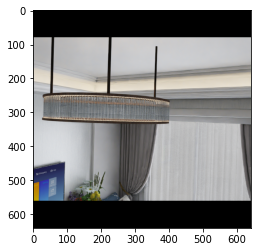

In [16]:
plt.imshow(image_t)
#plt.imshow(gt_masks[:,:,0])
print(gt_boxes)
print(image_meta)
print(gt_class_ids)

In [ ]:
a = modellib.data_generator(dataset_train, config_stage1, shuffle=True, augment=False, augmentation=None,
                   random_rois=0, batch_size=1, detection_targets=False,
                   no_augmentation_sources=None)
print(a)

In [ ]:
# inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
#                           batch_gt_class_ids, batch_gt_boxes, batch_gt_masks, batch_gt_R, batch_gt_Kmat]

inputs, output = next(a)
for i, input_i in enumerate(inputs):
    #print("{}'th input is: {}".format(i, input_i))
    print("shape of {}'ths input is: {}".format(i, input_i.shape))


In [ ]:
print(np.where(inputs[2]>0))